In [1]:
import pandas as pd
import numpy as np

In [2]:
nrp_em = pd.read_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\rawdata\production_values_w_prices-EM.csv", index_col=0)
nrp_l1 = pd.read_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\rawdata\NR_Production-Price-Reserves-LEO.csv")
nrp_l2 = pd.read_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\rawdata\NR_final_LEO.csv")

In [3]:
# Production Data Complete
nrp_l2 = nrp_l2[(nrp_l2["Year"]>=1995)&(nrp_l2["Metric"].isin(["Production", "Reserves"]))][["Country", "Metric", "Year", "Resource", "Value"]]

# World Production Data Complete
nrp_world = nrp_l1[(nrp_l1["Country Code"] == "OWID_WRL") & nrp_l1["Metric"].isin(["Production", "Reserves"])][["Country Name", "Metric", "Year", "Resource", "Value"]]
nrp_world.rename(columns={"Country Name": "Country"}, inplace=True)
nrp_world['Resource'] = nrp_world['Resource'].replace({
    'Aluminum': 'Aluminium',
    'Platinum group metals': 'Platinum Group',
    'Rare earths': 'Rare Earth'
})

# Price Data 1
price_l = nrp_l1[(nrp_l1["Year"]>=1995) &(nrp_l1["Metric"]=="Unit Value")][["Year", "Resource", "Value"]]
price_l.rename(columns={"Value": "Price"}, inplace=True)
price_l['Resource'] = price_l['Resource'].replace({
    'Aluminum': 'Aluminium',
    'Platinum group metals': 'Platinum Group',
    'Rare earths': 'Rare Earth'
})

# Price Data 2
nrp_em = nrp_em[nrp_em["Year"]>=1995][["Country", "Year", "Resource", "Price"]]
nrp_em.rename(columns={"Price":"Price2"}, inplace=True)
nrp_em_prices = nrp_em[["Year", "Resource", "Price2"]].drop_duplicates()


## Price Data

In [4]:
prices = pd.merge(price_l, nrp_em_prices, on=["Year","Resource"], how="outer")
prices["Price"] = prices["Price"].fillna(prices["Price2"])
prices['Resource'] = prices['Resource'].replace({
    'Aluminum': 'Aluminium',
    'Platinum group metals': 'Platinum Group',
    'Rare earths': 'Rare Earth'
})
prices.drop_duplicates(inplace=True)

## Production Data

In [5]:
nrp = pd.concat([nrp_l2, nrp_world], ignore_index=True)

In [6]:
nrpv = pd.merge(nrp, prices[["Year", "Resource", "Price"]], on=["Year", "Resource"], how="left")
nrpv = nrpv[nrpv["Year"]>=1995]

## Addressing Missing Value in Price/Production

In [7]:
# Missing Price3 values by Resource and Year
pd.set_option("display.max_columns", 200)

price_missing = nrpv[(nrpv["Metric"] == "Production") & (nrpv["Price"].isna())]
print("\nMissing Price3 by Resource and Year:")
print(price_missing.groupby(["Resource", "Year"]).size().unstack(fill_value=0))


Missing Price3 by Resource and Year:
Year                 1995  1996  1997  1998  1999  2000  2001  2002  2003  \
Resource                                                                    
Aluminium               0     0     0     0     0     0     0     0     0   
Bauxite                 0     0     0     0     0     0     0     0     0   
Cadmium                 0     0     0     0     0     0     0     0     0   
Cobalt                  0     0     0     0     0     0     0     0     0   
Copper                  0     0     0     0     0     0     0     0     0   
Gold                    0     0     0     0     0     0     0     0     0   
Iron ore                0     0     0     0     0     0     0     0     0   
Lead                    0     0     0     0     0     0     0     0     0   
Lithium                 0     0     0     0     0     0     0     0     0   
Magnesium compounds     0     0     0     0     0     0     0     0     0   
Manganese               0     0     0 

In [8]:
# Create complete index of all Resource-Year combinations
resources = nrpv[nrpv["Metric"] == "Production"]["Resource"].unique()
years = range(1995, 2024)  # 1995-2023

# Create all combinations
from itertools import product
complete_index = pd.DataFrame(
    list(product(resources, years)),
    columns=["Resource", "Year"]
)

# Filter for Production metric and merge with complete index
production_data = nrpv[nrpv["Metric"] == "Production"][["Resource", "Year", "Value"]]

# Merge to identify all missing combinations
complete_data = complete_index.merge(
    production_data,
    on=["Resource", "Year"],
    how="left"
)

# Now check missing values
print("\nMissing Production Values by Resource and Year:")
missing_matrix = complete_data[complete_data["Value"].isna()].groupby(["Resource", "Year"]).size().unstack(fill_value=0)

# Show as binary (1 = missing, 0 = present)
all_combinations = complete_data.pivot_table(
    index="Resource",
    columns="Year", 
    values="Value",
    aggfunc="count",
    fill_value=0
)
missing_binary = (all_combinations == 0).astype(int)

print(missing_binary)

# Summary statistics
print("\nMissing data summary by Resource:")
print(complete_data.groupby("Resource")["Value"].apply(lambda x: x.isna().sum()))


Missing Production Values by Resource and Year:
Year                 1995  1996  1997  1998  1999  2000  2001  2002  2003  \
Resource                                                                    
Aluminium               0     0     0     0     0     0     0     0     0   
Bauxite                 0     0     0     0     0     0     0     0     0   
Cadmium                 0     0     0     0     0     0     0     0     0   
Coal                    0     0     0     0     0     0     0     0     0   
Cobalt                  0     0     0     0     0     0     0     0     0   
Copper                  0     0     0     0     0     0     0     0     0   
Gold                    0     0     0     0     0     0     0     0     0   
Iron ore                0     0     0     0     0     0     0     0     0   
Lead                    0     0     0     0     0     0     0     0     0   
Lithium                 0     0     0     0     0     0     0     0     0   
Magnesium compounds     0  

In [9]:
nrpv = nrpv[(~nrpv["Resource"].isin(["Petroleum", "Platinum Group"]))]
nrpv["Country"] = nrpv["Country"].replace({'Venezuela: Orinoco Belt': 'Venezuela, RB', "US": "United States", "Congo": "Congo, Rep.", "Democratic Republic of Congo": "Congo, Dem. Rep.", 'DR Congo': "Congo, Dem. Rep.", "Republic of Congo ": "Congo, Rep.","Republic of Congo": "Congo, Rep.", "Brunei": "Brunei Darussalam", "Burma":"Myanmar", "Czech Republic": "Czechia", "Egypt": "Egypt, Arab Rep.", "Iran": "Iran, Islamic Rep.", "Kyrgyzstan":"Kyrgyz Republic", "Laos": "Lao PDR", "South Korea": "Korea, Rep.","Slovakia":"Slovak Republic", "North Korea": "Korea, Dem. People's Rep.", "Syria": "Syrian Arab Republic", "Trinidad & Tobago":"Trinidad and Tobago", "Turkey": "Turkiye", "Venezuela": "Venezuela, RB", "Yemen": "Yemen, Rep.", "Vietnam": "Viet Nam"})
# Delete countries
non_country_entity = ['                 OPEC', '                 Non-OPEC ', 'Central America', 'Eastern Africa', 'Middle Africa', 'Western Africa']
nrpv = nrpv[~nrpv["Country"].isin(non_country_entity)]
nrpv

,Country,Metric,Year,Resource,Value,Price
0,Canada,Production,1995,Oil,2.402128e+06,19.800516
1,Mexico,Production,1995,Oil,3.054768e+06,19.800516
2,United States,Production,1995,Oil,8.321639e+06,19.800516
3,Argentina,Production,1995,Oil,7.579162e+05,19.800516
4,Brazil,Production,1995,Oil,7.149000e+05,19.800516
...,...,...,...,...,...,...
22275,World,Production,2020,Zinc,1.200000e+07,1540.000000
22276,World,Production,2021,Zinc,1.270000e+07,1940.000000
22277,World,Production,2022,Zinc,1.250000e+07,2330.000000
22278,World,Production,2023,Zinc,1.210000e+07,NaN


In [10]:
nrpv = nrpv.drop_duplicates()

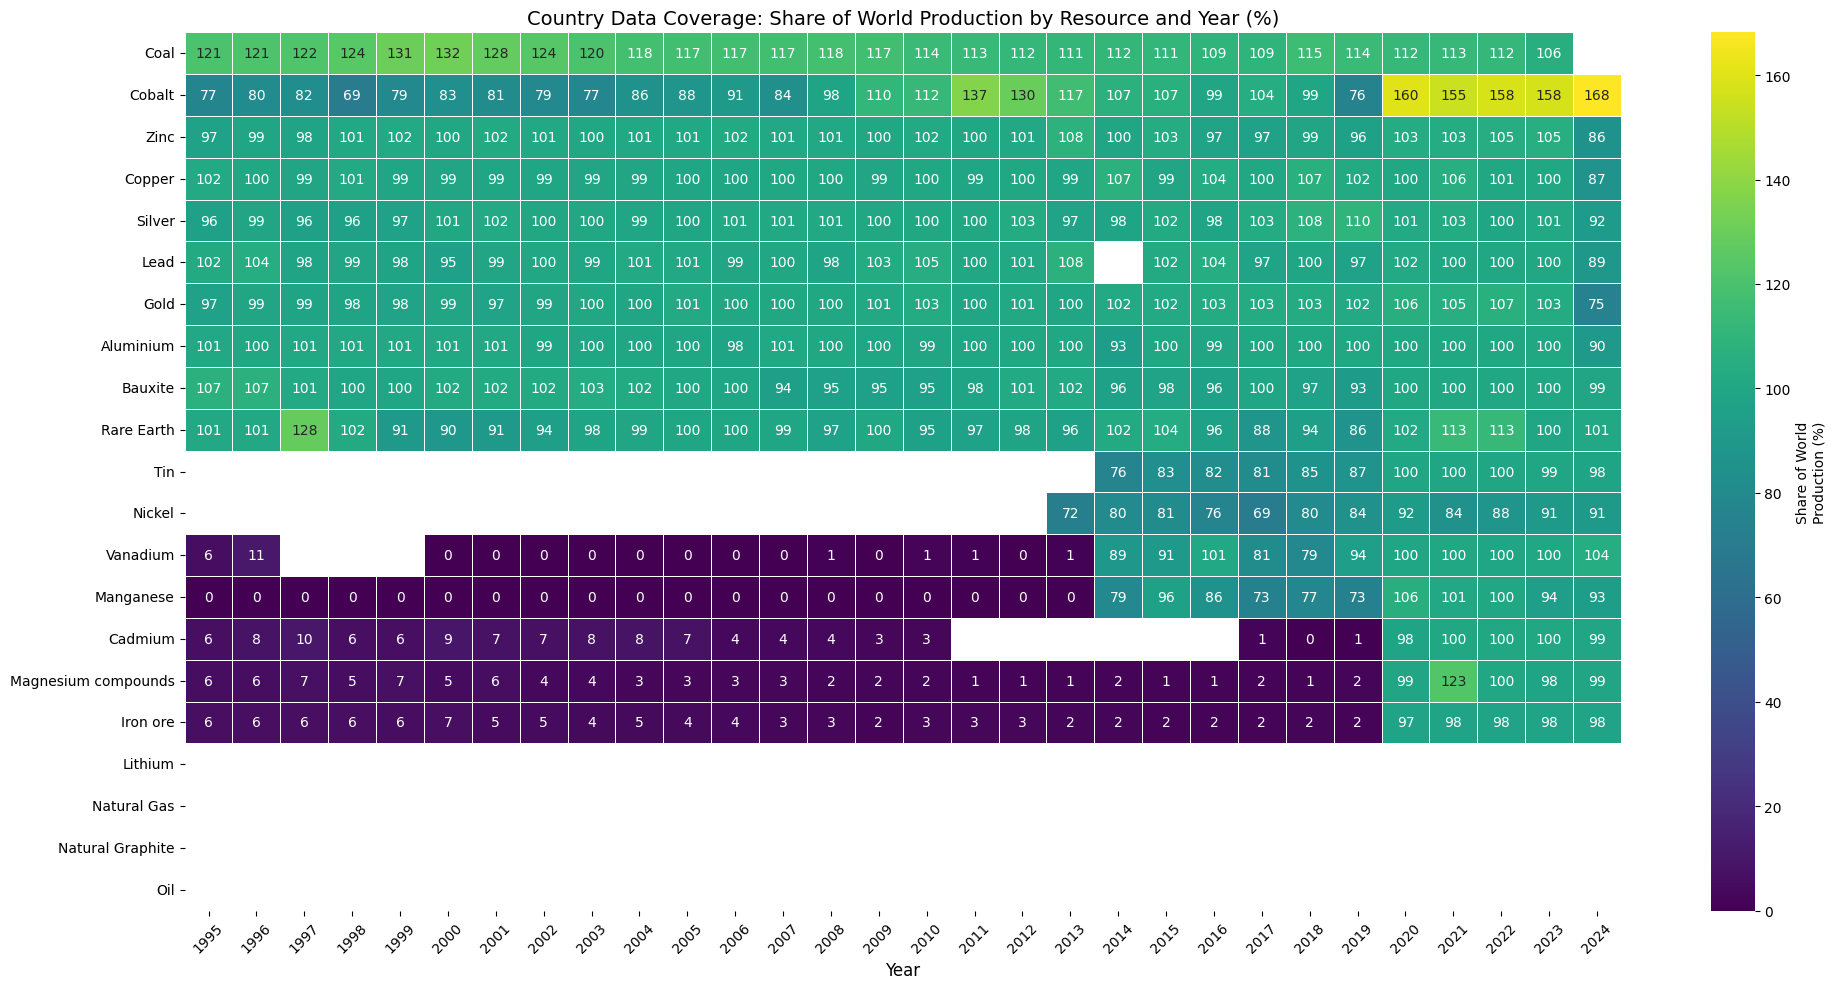

In [11]:
# Filter for Production metric only
prod = nrpv[nrpv["Metric"] == "Production"].copy()

# Separate Global and World production
global_prod = prod[prod["Country"] == "Global"][["Year", "Resource", "Value"]].copy()
global_prod.rename(columns={"Value": "Global_Production"}, inplace=True)

world_prod = prod[prod["Country"] == "World"][["Year", "Resource", "Value"]].copy()
world_prod.rename(columns={"Value": "World_Production"}, inplace=True)

# Merge Global and World, prioritize Global
reference_prod = pd.merge(global_prod, world_prod, on=["Year", "Resource"], how="outer")
reference_prod["Reference_Production"] = reference_prod["Global_Production"].fillna(reference_prod["World_Production"])

# Filter country production (exclude both Global and World)
country_prod = prod[~prod["Country"].isin(["World", "Global"])].copy()

# Calculate total production by countries (excluding World) per Resource and Year
country_total = country_prod.groupby(["Year", "Resource"])["Value"].sum().reset_index()
country_total.rename(columns={"Value": "Country_Total"}, inplace=True)

# Merge with reference production (Global preferred, World as fallback)
share_df = pd.merge(country_total, reference_prod[["Year", "Resource", "Reference_Production"]], 
                    on=["Year", "Resource"], how="left")

# Calculate share (as percentage)
share_df["Share"] = (share_df["Country_Total"] / share_df["Reference_Production"]) * 100

# Pivot for heatmap (Resources as rows, Years as columns)
share_pivot = share_df.pivot(index="Resource", columns="Year", values="Share")

# Sort by average share across years (descending)
share_pivot["avg"] = share_pivot.mean(axis=1)
share_pivot = share_pivot.sort_values("avg", ascending=False)
share_pivot.drop(columns="avg", inplace=True)

# Create heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.heatmap(share_pivot, 
            annot=True, 
            fmt=".0f", 
            cmap="viridis",
            cbar_kws={"label": "Share of World\nProduction (%)"},
            linewidths=0.5)

plt.title("Country Data Coverage: Share of World Production by Resource and Year (%)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# =============================================================================
# STEP 1: Define target minerals and prepare data
# =============================================================================

target_minerals = ["Tin", "Nickel", "Vanadium", "Manganese", "Cadmium", 
                   "Magnesium compounds", "Iron ore"]

# Filter for Production metric only
prod = nrpv[nrpv["Metric"] == "Production"].copy()

# Get reference production (Global preferred, World as fallback)
global_prod = prod[prod["Country"] == "Global"][["Year", "Resource", "Value"]].copy()
global_prod.rename(columns={"Value": "Global_Production"}, inplace=True)

world_prod = prod[prod["Country"] == "World"][["Year", "Resource", "Value"]].copy()
world_prod.rename(columns={"Value": "World_Production"}, inplace=True)

reference_prod = pd.merge(global_prod, world_prod, on=["Year", "Resource"], how="outer")
reference_prod["Reference_Production"] = reference_prod["Global_Production"].fillna(reference_prod["World_Production"])

# Country production (excluding Global and World)
country_prod = prod[~prod["Country"].isin(["World", "Global"])].copy()

print("Step 1 Complete: Data prepared")
print(f"Target minerals: {target_minerals}")
print(f"Years in data: {sorted(prod['Year'].unique())[:5]} ... {sorted(prod['Year'].unique())[-5:]}")

# =============================================================================
# STEP 2: Calculate current shares by country/resource/year
# =============================================================================

# Merge country production with reference production
country_with_ref = pd.merge(
    country_prod[["Country", "Year", "Resource", "Value"]], 
    reference_prod[["Year", "Resource", "Reference_Production"]], 
    on=["Year", "Resource"], 
    how="left"
)

# Calculate each country's share of reference production
country_with_ref["Country_Share"] = country_with_ref["Value"] / country_with_ref["Reference_Production"]

# Also calculate total country coverage (sum of all countries / reference)
country_total = country_prod.groupby(["Year", "Resource"])["Value"].sum().reset_index()
country_total.rename(columns={"Value": "Country_Total"}, inplace=True)
country_total = pd.merge(country_total, reference_prod[["Year", "Resource", "Reference_Production"]], 
                         on=["Year", "Resource"], how="left")
country_total["Coverage"] = (country_total["Country_Total"] / country_total["Reference_Production"]) * 100

print("\nStep 2 Complete: Shares calculated")
print("\nCurrent coverage for target minerals (sample):")
print(country_total[country_total["Resource"].isin(target_minerals)].pivot(
    index="Resource", columns="Year", values="Coverage").iloc[:, :10].round(1))

# =============================================================================
# STEP 3: Find the earliest year with >70% coverage for each target mineral
# =============================================================================

threshold_years = {}

for mineral in target_minerals:
    mineral_coverage = country_total[
        (country_total["Resource"] == mineral) & 
        (country_total["Coverage"] > 70)
    ].sort_values("Year")
    
    if len(mineral_coverage) > 0:
        earliest_year = mineral_coverage["Year"].min()
        threshold_years[mineral] = earliest_year
    else:
        threshold_years[mineral] = None
        print(f"WARNING: {mineral} never reaches 70% coverage")

print("\nStep 3 Complete: Threshold years identified")
print("\nEarliest year with >70% coverage for each mineral:")
for mineral, year in threshold_years.items():
    print(f"  {mineral}: {year}")

# =============================================================================
# STEP 4: Get country shares at the threshold year for each mineral
# =============================================================================

# Store the constant shares for each mineral
constant_shares = {}

for mineral, threshold_year in threshold_years.items():
    if threshold_year is None:
        continue
    
    # Get country shares at the threshold year
    shares_at_threshold = country_with_ref[
        (country_with_ref["Resource"] == mineral) & 
        (country_with_ref["Year"] == threshold_year) &
        (country_with_ref["Value"] > 0)  # Only countries with production
    ][["Country", "Country_Share"]].copy()
    
    constant_shares[mineral] = shares_at_threshold

print("\nStep 4 Complete: Country shares at threshold year")
print("\nExample - Country shares for first target mineral:")
first_mineral = [m for m in target_minerals if threshold_years.get(m) is not None][0]
print(f"\n{first_mineral} (threshold year: {threshold_years[first_mineral]}):")
print(constant_shares[first_mineral].sort_values("Country_Share", ascending=False).head(10).to_string())

# =============================================================================
# STEP 5: Create backfilled production data
# =============================================================================

backfilled_rows = []

for mineral, threshold_year in threshold_years.items():
    if threshold_year is None:
        continue
    
    # Get years before the threshold year
    years_to_backfill = sorted([y for y in prod["Year"].unique() if y < threshold_year])
    
    # Get reference production for those years
    ref_for_backfill = reference_prod[
        (reference_prod["Resource"] == mineral) & 
        (reference_prod["Year"].isin(years_to_backfill))
    ][["Year", "Reference_Production"]].copy()
    
    # Get the constant country shares
    shares = constant_shares[mineral]
    
    # Cross join: each year × each country
    for _, ref_row in ref_for_backfill.iterrows():
        year = ref_row["Year"]
        ref_prod_value = ref_row["Reference_Production"]
        
        # Skip if no reference production available
        if pd.isna(ref_prod_value):
            continue
        
        for _, share_row in shares.iterrows():
            country = share_row["Country"]
            country_share = share_row["Country_Share"]
            
            # Calculate backfilled production
            backfilled_value = ref_prod_value * country_share
            
            backfilled_rows.append({
                "Country": country,
                "Year": year,
                "Resource": mineral,
                "Value": backfilled_value,
                "Metric": "Production",
                "Source": "Backfilled"
            })

backfilled_df = pd.DataFrame(backfilled_rows)

print("\nStep 5 Complete: Backfilled data created")
print(f"Total backfilled rows: {len(backfilled_df)}")
print(f"\nBackfilled data by mineral:")
print(backfilled_df.groupby("Resource").agg(
    Years=("Year", lambda x: f"{x.min()}-{x.max()}"),
    Countries=("Country", "nunique"),
    Rows=("Year", "count")
))

# =============================================================================
# STEP 6: Verification - Check one mineral in detail
# =============================================================================

print("\n" + "="*80)
print("VERIFICATION")
print("="*80)

# Pick a mineral to verify
verify_mineral = first_mineral
verify_threshold = threshold_years[verify_mineral]

print(f"\nVerifying: {verify_mineral}")
print(f"Threshold year: {verify_threshold}")

# Show the shares used
print(f"\nCountry shares at {verify_threshold} (used for backfill):")
verify_shares = constant_shares[verify_mineral].sort_values("Country_Share", ascending=False)
print(verify_shares.head(10).to_string())
print(f"Sum of shares: {verify_shares['Country_Share'].sum():.2%}")

# Show backfilled data for a sample year
sample_year = years_to_backfill[0] if years_to_backfill else None
if sample_year:
    print(f"\nBackfilled production for {verify_mineral} in {sample_year}:")
    sample_backfill = backfilled_df[
        (backfilled_df["Resource"] == verify_mineral) & 
        (backfilled_df["Year"] == sample_year)
    ].sort_values("Value", ascending=False)
    
    ref_prod_sample = reference_prod[
        (reference_prod["Resource"] == verify_mineral) & 
        (reference_prod["Year"] == sample_year)
    ]["Reference_Production"].values[0]
    
    print(f"Reference (Global/World) production: {ref_prod_sample:,.0f}")
    print(f"\nTop countries (backfilled):")
    print(sample_backfill.head(10)[["Country", "Value"]].to_string())
    print(f"\nSum of backfilled country values: {sample_backfill['Value'].sum():,.0f}")

# =============================================================================
# STEP 7: Summary table - threshold years and shares by mineral
# =============================================================================

print("\n" + "="*80)
print("SUMMARY: Threshold Years and Top Country Shares")
print("="*80)

for mineral in target_minerals:
    threshold = threshold_years.get(mineral)
    if threshold is None:
        print(f"\n{mineral}: No year with >70% coverage found")
        continue
    
    print(f"\n{mineral} (threshold: {threshold}):")
    shares = constant_shares[mineral].sort_values("Country_Share", ascending=False)
    top_5 = shares.head(5)
    for _, row in top_5.iterrows():
        print(f"  {row['Country']}: {row['Country_Share']:.1%}")
    if len(shares) > 5:
        print(f"  ... and {len(shares)-5} more countries")

# =============================================================================
# STEP 8: Integrate backfilled data into main dataset
# =============================================================================

# Remove World and Global from nrpv
nrpv_clean = nrpv[~nrpv["Country"].isin(["World", "Global"])].copy()

# Add Source column to original data
nrpv_clean["Source"] = "Original"

# Prepare backfilled data to match nrpv columns
backfilled_for_merge = backfilled_df.copy()

# Add Price column (merge from prices)
backfilled_for_merge = pd.merge(
    backfilled_for_merge,
    prices[["Year", "Resource", "Price"]],
    on=["Year", "Resource"],
    how="left"
)

# Ensure column order matches
nrpv_columns = list(nrpv_clean.columns)
backfilled_for_merge = backfilled_for_merge[nrpv_columns]

# Remove any existing data for target minerals in backfill years 
# (to avoid duplicates if there was partial data)
for mineral, threshold_year in threshold_years.items():
    if threshold_year is None:
        continue
    # Remove original data for this mineral before threshold year
    mask = (nrpv_clean["Resource"] == mineral) & \
           (nrpv_clean["Year"] < threshold_year) & \
           (nrpv_clean["Metric"] == "Production")
    nrpv_clean = nrpv_clean[~mask]

# Concatenate original and backfilled data
nrpv_final = pd.concat([nrpv_clean, backfilled_for_merge], ignore_index=True)

# Sort for cleaner output
nrpv_final = nrpv_final.sort_values(["Resource", "Country", "Year", "Metric"]).reset_index(drop=True)

print("\n" + "="*80)
print("STEP 8: Integration Complete")
print("="*80)
print(f"\nOriginal nrpv shape (excl. World/Global): {nrpv_clean.shape}")
print(f"Backfilled rows added: {len(backfilled_for_merge)}")
print(f"Final nrpv shape: {nrpv_final.shape}")

print("\nVerification - Row counts by mineral and source (Production only):")
verification = nrpv_final[nrpv_final["Metric"] == "Production"].groupby(
    ["Resource", "Source"]
).size().unstack(fill_value=0)
print(verification[verification.index.isin(target_minerals)])

# Update nrpv with the final integrated dataset
nrpv = nrpv_final.copy()
print("\n✓ nrpv has been updated with backfilled data (World/Global removed)")

Step 1 Complete: Data prepared
Target minerals: ['Tin', 'Nickel', 'Vanadium', 'Manganese', 'Cadmium', 'Magnesium compounds', 'Iron ore']
Years in data: [np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999)] ... [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Step 2 Complete: Shares calculated

Current coverage for target minerals (sample):
Year                 1995  1996  1997  1998  1999  2000  2001  2002  2003  \
Resource                                                                    
Cadmium               6.3   8.1  10.1   6.1   5.9   9.3   7.2   7.2   7.9   
Iron ore              6.1   6.1   6.1   6.0   5.7   6.5   4.9   5.3   4.5   
Magnesium compounds   5.6   5.9   6.6   5.3   6.7   4.8   5.8   3.7   3.9   
Manganese             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Nickel                NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Tin                   NaN   NaN   NaN   NaN   NaN   NaN   N

### Data from IEA

| Year | Base Metals | Battery Metals | Rare Earth |
|------|-------------|----------------|------------|
| 2021 | 44.82       | 50.13          | 90.52      |
| 2022 | -2.87       | 97.97          | 34.05      |
| 2023 | -11.82      | -28.13         | -35.21     |
| 2024 | -0.26       | -43.92         | -29.26     |


In [13]:
# Year-over-year price changes (%)
# Copper and Nickel are Base Metals, Rare Earth has its own column
price_changes_2021 = {
    "Copper": 44.82477588,      # Base Metals
    "Nickel": 50.13077594,      # Battery Metals
    "Rare Earth": 90.52167524   # Rare Earth
}

# Apply 2021 price adjustment based on 2020 price * (1 + % change)
for resource, pct_change in price_changes_2021.items():
    mask_2021 = (nrpv["Resource"] == resource) & (nrpv["Year"] == 2021)
    mask_2020 = (nrpv["Resource"] == resource) & (nrpv["Year"] == 2020)
    
    price_2020 = nrpv.loc[mask_2020, "Price"].values
    
    if len(price_2020) > 0:
        price_2021 = price_2020[0] * (1 + pct_change / 100)
        nrpv.loc[mask_2021, "Price"] = price_2021
        
        print(f"{resource}:")
        print(f"  2020 price: {price_2020[0]:,.2f}")
        print(f"  YoY change: {pct_change:.2f}%")
        print(f"  2021 price: {price_2021:,.2f}")
        print()

nrpv

Copper:
  2020 price: 3,980.00
  YoY change: 44.82%
  2021 price: 5,764.03

Nickel:
  2020 price: 8,670.00
  YoY change: 50.13%
  2021 price: 13,016.34

Rare Earth:
  2020 price: 3,230.00
  YoY change: 90.52%
  2021 price: 6,153.85



,Country,Metric,Year,Resource,Value,Price,Source
0,Argentina,Production,1995.0,Aluminium,185457.0,2020.0,Original
1,Argentina,Production,1996.0,Aluminium,185934.0,1630.0,Original
2,Argentina,Production,1997.0,Aluminium,187157.0,1730.0,Original
3,Argentina,Production,1998.0,Aluminium,373310.0,1440.0,Original
4,Argentina,Production,1999.0,Aluminium,206395.0,1420.0,Original
...,...,...,...,...,...,...,...
22501,Zambia,Production,2019.0,Zinc,0.0,1750.0,Original
22502,Zambia,Production,2020.0,Zinc,245.0,1540.0,Original
22503,Zambia,Production,2021.0,Zinc,500.0,1940.0,Original
22504,Zambia,Production,2022.0,Zinc,400.0,2330.0,Original


In [14]:
nrpv = nrpv[(nrpv["Year"]<2022) & (~nrpv["Resource"].isin(["Petroleum", "Platinum group metals", "Iron ore"]))]
nrpv.head()

,Country,Metric,Year,Resource,Value,Price,Source
0,Argentina,Production,1995.0,Aluminium,185457.0,2020.0,Original
1,Argentina,Production,1996.0,Aluminium,185934.0,1630.0,Original
2,Argentina,Production,1997.0,Aluminium,187157.0,1730.0,Original
3,Argentina,Production,1998.0,Aluminium,373310.0,1440.0,Original
4,Argentina,Production,1999.0,Aluminium,206395.0,1420.0,Original


In [15]:
nrpv = nrpv.pivot_table(
    index=["Country", "Year", "Resource", "Source", "Price"],
    columns="Metric",
    values="Value"
).reset_index()

nrpv["Production_TotalValue"] = nrpv["Production"]*nrpv["Price"]
nrpv["Reserves_TotalValue"] = nrpv["Reserves"]*nrpv["Price"]

nrpv

Metric,Country,Year,Resource,Source,Price,Production,Reserves,Production_TotalValue,Reserves_TotalValue
0,Afghanistan,1995.0,Coal,Original,4.581266e+01,140000.000,NaN,6.413772e+06,NaN
1,Afghanistan,1996.0,Coal,Original,4.155228e+01,200000.000,NaN,8.310457e+06,NaN
2,Afghanistan,1997.0,Coal,Original,3.674010e+01,185000.000,NaN,6.796918e+06,NaN
3,Afghanistan,1998.0,Coal,Original,2.923083e+01,190000.000,NaN,5.553858e+06,NaN
4,Afghanistan,1999.0,Coal,Original,2.484547e+01,2000.000,NaN,4.969094e+04,NaN
...,...,...,...,...,...,...,...,...,...
17161,Zimbabwe,2021.0,Coal,Original,5.934994e+01,3239215.090,NaN,1.922472e+08,NaN
17162,Zimbabwe,2021.0,Copper,Original,5.764026e+03,8650.000,NaN,4.985883e+07,NaN
17163,Zimbabwe,2021.0,Gold,Original,3.480000e+07,31.477,NaN,1.095400e+09,NaN
17164,Zimbabwe,2021.0,Lithium,Original,3.730000e+03,710.000,NaN,2.648300e+06,NaN


In [16]:
hydrocarbons = ['Oil', 'Natural Gas', 'Coal']

precious_metals = ['Gold', 'Silver']

subsoil = [
    'Bauxite', 'Copper', 'Aluminium', 'Lead', 'Lithium', 
    'Zinc', 'Cadmium', 'Cobalt', 'Iron ore', 'Magnesium compounds', 
    'Manganese', 'Nickel', 'Rare earths', 'Tin', 'Vanadium', 
    'Natural Graphite']

def classify_resource(x):
    if x in hydrocarbons:
        return 'Hydrocarbons'
    elif x in subsoil:
        return 'Subsoil Metals'
    elif x in precious_metals:
        return 'Precious Metals'
    else:
        return 'Others'

nrpv['Resource Category'] = nrpv['Resource'].apply(classify_resource)
nrpv

Metric,Country,Year,Resource,Source,Price,Production,Reserves,Production_TotalValue,Reserves_TotalValue,Resource Category
0,Afghanistan,1995.0,Coal,Original,4.581266e+01,140000.000,NaN,6.413772e+06,NaN,Hydrocarbons
1,Afghanistan,1996.0,Coal,Original,4.155228e+01,200000.000,NaN,8.310457e+06,NaN,Hydrocarbons
2,Afghanistan,1997.0,Coal,Original,3.674010e+01,185000.000,NaN,6.796918e+06,NaN,Hydrocarbons
3,Afghanistan,1998.0,Coal,Original,2.923083e+01,190000.000,NaN,5.553858e+06,NaN,Hydrocarbons
4,Afghanistan,1999.0,Coal,Original,2.484547e+01,2000.000,NaN,4.969094e+04,NaN,Hydrocarbons
...,...,...,...,...,...,...,...,...,...,...
17161,Zimbabwe,2021.0,Coal,Original,5.934994e+01,3239215.090,NaN,1.922472e+08,NaN,Hydrocarbons
17162,Zimbabwe,2021.0,Copper,Original,5.764026e+03,8650.000,NaN,4.985883e+07,NaN,Subsoil Metals
17163,Zimbabwe,2021.0,Gold,Original,3.480000e+07,31.477,NaN,1.095400e+09,NaN,Precious Metals
17164,Zimbabwe,2021.0,Lithium,Original,3.730000e+03,710.000,NaN,2.648300e+06,NaN,Subsoil Metals


In [17]:
# Step 1: Calculate total production value by country, year, and resource category
category_totals = nrpv.groupby(['Country', 'Year', 'Resource Category'])['Production_TotalValue'].sum().reset_index()

# Step 2: Calculate total production value by country and year (across all categories)
country_year_totals = nrpv.groupby(['Country', 'Year'])['Production_TotalValue'].sum().reset_index()
country_year_totals.rename(columns={'Production_TotalValue': 'Total_Production_Value'}, inplace=True)

# Step 3: Pivot category totals to get each category as a column
category_pivot = category_totals.pivot_table(
    index=['Country', 'Year'], 
    columns='Resource Category', 
    values='Production_TotalValue', 
    fill_value=0
).reset_index()

# Step 4: Merge with country-year totals
merged = category_pivot.merge(country_year_totals, on=['Country', 'Year'])

# Step 5: Calculate shares and create dummy variables (1 if share > 50%)
merged['Hydrocarbons_Dominant'] = (merged['Hydrocarbons'] / merged['Total_Production_Value'] > 0.5).astype(int)
merged['Subsoil_Metals_Dominant'] = (merged['Subsoil Metals'] / merged['Total_Production_Value'] > 0.5).astype(int)
merged['Precious_Metals_Dominant'] = (merged['Precious Metals'] / merged['Total_Production_Value'] > 0.5).astype(int)

# Step 6: Aggregate reserves and production quantities by country and year
reserves_totals = nrpv.groupby(['Country', 'Year']).agg({
    'Reserves_TotalValue': 'sum',
    'Reserves': 'sum',
    'Production': 'sum'
}).reset_index()
reserves_totals.rename(columns={
    'Reserves_TotalValue': 'Total_Reserves_Value',
    'Reserves': 'Total_Reserves',
    'Production': 'Total_Production'
}, inplace=True)

# Step 7: Create final dataset
nrpa = merged[['Country', 'Year', 'Total_Production_Value']].merge(
    reserves_totals, on=['Country', 'Year'], how='left'
)
nrpa['Hydrocarbons_Dominant'] = merged['Hydrocarbons_Dominant']
nrpa['Subsoil_Metals_Dominant'] = merged['Subsoil_Metals_Dominant']
nrpa['Precious_Metals_Dominant'] = merged['Precious_Metals_Dominant']

# Reorder columns for clarity
nrpa = nrpa[['Country', 'Year', 'Total_Production', 'Total_Reserves', 
             'Total_Production_Value', 'Total_Reserves_Value', 
             'Hydrocarbons_Dominant', 'Subsoil_Metals_Dominant', 'Precious_Metals_Dominant']]
nrpa

,Country,Year,Total_Production,Total_Reserves,Total_Production_Value,Total_Reserves_Value,Hydrocarbons_Dominant,Subsoil_Metals_Dominant,Precious_Metals_Dominant
0,Afghanistan,1995.0,140000.000,0.0,6.413772e+06,0.0,1,0,0
1,Afghanistan,1996.0,200000.000,0.0,8.310457e+06,0.0,1,0,0
2,Afghanistan,1997.0,185000.000,0.0,6.796918e+06,0.0,1,0,0
3,Afghanistan,1998.0,190000.000,0.0,5.553858e+06,0.0,1,0,0
4,Afghanistan,1999.0,2000.000,0.0,4.969094e+04,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...
3853,Zimbabwe,2017.0,2937664.409,0.0,8.136642e+08,0.0,0,0,1
3854,Zimbabwe,2018.0,3358477.596,0.0,1.146441e+09,0.0,0,0,1
3855,Zimbabwe,2019.0,2636941.922,0.0,9.773953e+08,0.0,0,0,1
3856,Zimbabwe,2020.0,2714307.895,0.0,8.555464e+08,0.0,0,0,1


In [18]:
feasible_countries = nrpa["Country"].tolist()

### need to aggregate and make dummies

In [19]:
df = pd.read_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\workingdata\master_data_wide.csv", index_col=0)

In [20]:
df

,Country Code,Country Name,Year,Access to electricity (% of population),Accountability index,Adjusted savings: gross savings (% of GNI),Adjusted savings: natural resources depletion (% of GNI),Adjusted savings: total (current US$),Agriculture,Capital depreciation rate,Capital stock (national accounts prices),Civil war,Clientelism index,"Death rates, crude per 1000 people",Domestic credit to private sector (% of GDP),Economic Complexity Index,Employment in agriculture (% of total employment),Employment in industry (% of total employment),Employment in services (% of total employment),"GDP per capita (constant prices, PPP)",General government net debt,General government structural balance,Government revenue,"Gross fixed capital formation, all, Constant prices, Percent of GDP",High-tech exports,Human capital index,Industry,"Inflation, consumer prices (annual %)",Landlocked,Lending interest rate (%),"Life expectancy at birth, total (years)",Manufacturing,Mineral rents (% of GDP),Mobile cellular subscriptions (per 100 people),Natural gas rents (% of GDP),Oil rents (% of GDP),Political corruption index,Political stability — estimate,"Primary net lending, General government, Percent of GDP",Production_Hydrocarbures,Production_Metals,Property rights,Real interest rate (%),Reserves_Hydrocarbures,Rule of law index,Services,Share of consumption in GDP,Share of government spending in GDP,Share of investment in GDP,TFP level (constant national prices),Total natural resources rents (% of GDP),Trade (% of GDP),Urban population (% of total population),"Use of IMF credit (DOD, current US$)",Welfare-relevant TFP,deliberative_dem,egalitarian_dem,electoral_dem,liberal_dem,participatory_dem
0,AFG,Afghanistan,1995,NaN,-1.118,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.821,14.403,NaN,-0.451,67.451958,9.298681,23.249360,NaN,NaN,NaN,NaN,33.241833,NaN,NaN,NaN,NaN,1.0,NaN,52.103,NaN,NaN,0.0,NaN,NaN,0.895,NaN,NaN,NaN,NaN,0.080,NaN,NaN,0.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3043587.0,NaN,NaN,0.027,0.041,0.094,0.022,0.025
1,AFG,Afghanistan,1996,NaN,-1.582,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.821,13.928,NaN,-0.477,67.170502,9.370286,23.459212,NaN,NaN,NaN,NaN,30.134079,NaN,NaN,NaN,NaN,1.0,NaN,52.830,NaN,NaN,0.0,NaN,NaN,0.852,-2.417,NaN,NaN,NaN,0.061,NaN,NaN,0.072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3190220.0,NaN,NaN,0.008,0.036,0.076,0.019,0.013
2,AFG,Afghanistan,1997,NaN,-1.697,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.848,13.651,NaN,0.063,66.859165,9.444642,23.696193,NaN,NaN,NaN,NaN,29.871860,NaN,NaN,NaN,NaN,1.0,NaN,53.212,NaN,NaN,0.0,NaN,NaN,0.791,NaN,NaN,NaN,NaN,0.061,NaN,NaN,0.099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3338510.0,NaN,NaN,0.007,0.040,0.073,0.022,0.013
3,AFG,Afghanistan,1998,NaN,-1.695,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.848,13.886,NaN,-0.278,66.506889,9.524054,23.969057,NaN,NaN,NaN,NaN,29.643407,NaN,NaN,NaN,NaN,1.0,NaN,52.487,NaN,NaN,0.0,NaN,NaN,0.791,-2.427,NaN,NaN,NaN,0.061,NaN,NaN,0.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3493981.0,NaN,NaN,0.007,0.040,0.073,0.022,0.013
4,AFG,Afghanistan,1999,NaN,-1.689,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.848,12.697,NaN,-0.249,66.093806,9.619578,24.286616,NaN,NaN,NaN,NaN,29.348911,NaN,NaN,NaN,NaN,1.0,NaN,54.532,NaN,NaN,0.0,NaN,NaN,0.791,NaN,NaN,NaN,NaN,0.061,NaN,NaN,0.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3657429.0,NaN,NaN,0.007,0.040,0.073,0.022,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6225,ZZB,NaN,2015,NaN,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.664,NaN,NaN,NaN,NaN,0.694,NaN,NaN,0.363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249,0.257,0.288,0.232,0.196
6226,ZZB,NaN,2016,NaN,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.664,NaN,NaN,NaN,NaN,0.694,NaN,NaN,0.344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [21]:
df = pd.merge(df, nrpa, left_on=["Country Name", "Year"], right_on=["Country", "Year"], how="left")
df

,Country Code,Country Name,Year,Access to electricity (% of population),Accountability index,Adjusted savings: gross savings (% of GNI),Adjusted savings: natural resources depletion (% of GNI),Adjusted savings: total (current US$),Agriculture,Capital depreciation rate,Capital stock (national accounts prices),Civil war,Clientelism index,"Death rates, crude per 1000 people",Domestic credit to private sector (% of GDP),Economic Complexity Index,Employment in agriculture (% of total employment),Employment in industry (% of total employment),Employment in services (% of total employment),"GDP per capita (constant prices, PPP)",General government net debt,General government structural balance,Government revenue,"Gross fixed capital formation, all, Constant prices, Percent of GDP",High-tech exports,Human capital index,Industry,"Inflation, consumer prices (annual %)",Landlocked,Lending interest rate (%),"Life expectancy at birth, total (years)",Manufacturing,Mineral rents (% of GDP),Mobile cellular subscriptions (per 100 people),Natural gas rents (% of GDP),Oil rents (% of GDP),Political corruption index,Political stability — estimate,"Primary net lending, General government, Percent of GDP",Production_Hydrocarbures,Production_Metals,Property rights,Real interest rate (%),Reserves_Hydrocarbures,Rule of law index,Services,Share of consumption in GDP,Share of government spending in GDP,Share of investment in GDP,TFP level (constant national prices),Total natural resources rents (% of GDP),Trade (% of GDP),Urban population (% of total population),"Use of IMF credit (DOD, current US$)",Welfare-relevant TFP,deliberative_dem,egalitarian_dem,electoral_dem,liberal_dem,participatory_dem,Country,Total_Production,Total_Reserves,Total_Production_Value,Total_Reserves_Value,Hydrocarbons_Dominant,Subsoil_Metals_Dominant,Precious_Metals_Dominant
0,AFG,Afghanistan,1995,NaN,-1.118,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.821,14.403,NaN,-0.451,67.451958,9.298681,23.249360,NaN,NaN,NaN,NaN,33.241833,NaN,NaN,NaN,NaN,1.0,NaN,52.103,NaN,NaN,0.0,NaN,NaN,0.895,NaN,NaN,NaN,NaN,0.080,NaN,NaN,0.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3043587.0,NaN,NaN,0.027,0.041,0.094,0.022,0.025,Afghanistan,140000.0,0.0,6.413772e+06,0.0,1.0,0.0,0.0
1,AFG,Afghanistan,1996,NaN,-1.582,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.821,13.928,NaN,-0.477,67.170502,9.370286,23.459212,NaN,NaN,NaN,NaN,30.134079,NaN,NaN,NaN,NaN,1.0,NaN,52.830,NaN,NaN,0.0,NaN,NaN,0.852,-2.417,NaN,NaN,NaN,0.061,NaN,NaN,0.072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3190220.0,NaN,NaN,0.008,0.036,0.076,0.019,0.013,Afghanistan,200000.0,0.0,8.310457e+06,0.0,1.0,0.0,0.0
2,AFG,Afghanistan,1997,NaN,-1.697,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.848,13.651,NaN,0.063,66.859165,9.444642,23.696193,NaN,NaN,NaN,NaN,29.871860,NaN,NaN,NaN,NaN,1.0,NaN,53.212,NaN,NaN,0.0,NaN,NaN,0.791,NaN,NaN,NaN,NaN,0.061,NaN,NaN,0.099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3338510.0,NaN,NaN,0.007,0.040,0.073,0.022,0.013,Afghanistan,185000.0,0.0,6.796918e+06,0.0,1.0,0.0,0.0
3,AFG,Afghanistan,1998,NaN,-1.695,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.848,13.886,NaN,-0.278,66.506889,9.524054,23.969057,NaN,NaN,NaN,NaN,29.643407,NaN,NaN,NaN,NaN,1.0,NaN,52.487,NaN,NaN,0.0,NaN,NaN,0.791,-2.427,NaN,NaN,NaN,0.061,NaN,NaN,0.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3493981.0,NaN,NaN,0.007,0.040,0.073,0.022,0.013,Afghanistan,190000.0,0.0,5.553858e+06,0.0,1.0,0.0,0.0
4,AFG,Afghanistan,1999,NaN,-1.689,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.848,12.697,NaN,-0.249,66.093806,9.619578,24.286616,NaN,NaN,NaN,NaN,29.348911,NaN,NaN,NaN,NaN,1.0,NaN,54.532,NaN,NaN,0.0,NaN,NaN,0.791,NaN,NaN,NaN,NaN,0.061,NaN,NaN,0.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3657429.0,NaN,NaN,0.007,0.040,0.073,0.022,0.013,Afghanistan,2000.0,0.0,4.969094e+04,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6225,ZZB,NaN,2015,NaN,0.100,NaN,NaN,NaN,NaN,NaN

## From missing value + correlation analysis

In [22]:
keep_vars = ['Country Code', 'Country Name', 'Year',
       'Access to electricity (% of population)',
       'Adjusted savings: gross savings (% of GNI)', 
       'Agriculture',
       'Capital depreciation rate',
       'Clientelism index', 
       'Death rates, crude per 1000 people',
       'Domestic credit to private sector (% of GDP)',
       'Economic Complexity Index',
       'GDP per capita (constant prices, PPP)', 
       'Government revenue',
       'Gross fixed capital formation, all, Constant prices, Percent of GDP',
       'Human capital index',
       'Industry',
       'Inflation, consumer prices (annual %)', 
       'Landlocked',
       'Lending interest rate (%)', 
       'Life expectancy at birth, total (years)',
       'Manufacturing', 
       'Mineral rents (% of GDP)',
       'Mobile cellular subscriptions (per 100 people)',
       'Natural gas rents (% of GDP)', 
       'Oil rents (% of GDP)',
       'Political corruption index', 
       'Political stability — estimate',
       'Primary net lending, General government, Percent of GDP',
       'Property rights',
       'Real interest rate (%)', 
       'Rule of law index',
       'Services', 
       'Share of consumption in GDP',
       'Share of government spending in GDP',
       'Share of investment in GDP',
       'Total natural resources rents (% of GDP)',
       'Trade (% of GDP)',
       'Urban population (% of total population)',
       'Use of IMF credit (DOD, current US$)', 
       'Total_Production',
       'Total_Reserves', 
       'Total_Production_Value',
       'Total_Reserves_Value',
       'Hydrocarbons_Dominant',
       'Subsoil_Metals_Dominant',
       'Precious_Metals_Dominant']


Missing Countries based on iterative analysis - see word document

In [23]:
omit_countries = ['BDI','BTN','CAF','ERI','FJI','GUY','ISL','MNE','NCL','PRK','SLB','SLE','SSD','SUR','SYR', 'GUF', 'PRK', 'TWN', 'NCL', 'SSD', 'CUB', 'ERI', 'TLS', 'AFG', 'TKM', 'SYR', 'MNE', 'KHM', 'XKX', 'BEN']


In [24]:
df = df[keep_vars]
df = df[df["Country Name"].isin(feasible_countries)]
df = df[~df["Country Code"].isin(omit_countries)]
df["Use of IMF credit (DOD, current US$)"] = df["Use of IMF credit (DOD, current US$)"].fillna(0)
df["Death rates, crude per 1000 people"] = df["Death rates, crude per 1000 people"].fillna(0)
cmaster = df

In [25]:
cmaster

,Country Code,Country Name,Year,Access to electricity (% of population),Adjusted savings: gross savings (% of GNI),Agriculture,Capital depreciation rate,Clientelism index,"Death rates, crude per 1000 people",Domestic credit to private sector (% of GDP),Economic Complexity Index,"GDP per capita (constant prices, PPP)",Government revenue,"Gross fixed capital formation, all, Constant prices, Percent of GDP",Human capital index,Industry,"Inflation, consumer prices (annual %)",Landlocked,Lending interest rate (%),"Life expectancy at birth, total (years)",Manufacturing,Mineral rents (% of GDP),Mobile cellular subscriptions (per 100 people),Natural gas rents (% of GDP),Oil rents (% of GDP),Political corruption index,Political stability — estimate,"Primary net lending, General government, Percent of GDP",Property rights,Real interest rate (%),Rule of law index,Services,Share of consumption in GDP,Share of government spending in GDP,Share of investment in GDP,Total natural resources rents (% of GDP),Trade (% of GDP),Urban population (% of total population),"Use of IMF credit (DOD, current US$)",Total_Production,Total_Reserves,Total_Production_Value,Total_Reserves_Value,Hydrocarbons_Dominant,Subsoil_Metals_Dominant,Precious_Metals_Dominant
25,AGO,Angola,1995,NaN,NaN,NaN,0.035367,0.840,18.700,NaN,-1.914,4214.831,NaN,51.161421,1.214912,NaN,2666.450593,0.0,206.250000,46.139,NaN,0.000000,0.014333,0.206519,41.018816,0.809,NaN,NaN,0.189,-84.095000,0.174,NaN,0.279740,0.248555,0.624452,44.210997,NaN,6056809.0,0.0,6.328546e+05,3125.0,1.253085e+07,61876.613480,1.0,0.0,0.0
26,AGO,Angola,1996,NaN,NaN,NaN,0.038398,0.840,18.445,NaN,-2.328,4533.696,39.104,67.195775,1.230892,NaN,4145.105982,0.0,217.875000,46.418,NaN,0.000000,0.022929,0.159734,39.074144,0.809,-2.062,NaN,0.189,-93.513459,0.174,NaN,0.214948,0.084098,0.734222,41.361717,NaN,6441501.0,0.0,7.159761e+05,3695.0,1.614997e+07,83346.553264,1.0,0.0,0.0
27,AGO,Angola,1997,NaN,NaN,NaN,0.040405,0.840,18.184,NaN,-1.570,4703.960,34.882,48.507818,1.247082,NaN,219.176721,0.0,37.750000,46.688,NaN,0.000000,0.047421,0.158566,37.349023,0.809,NaN,4.143154,0.189,-29.522707,0.174,NaN,0.293121,0.256249,0.551628,39.451489,NaN,6849440.0,0.0,7.410000e+05,3900.0,1.480903e+07,77942.237484,1.0,0.0,0.0
28,AGO,Angola,1998,NaN,NaN,NaN,0.040825,0.840,18.925,NaN,-1.579,4765.766,27.629,64.038521,1.263485,NaN,107.284822,0.0,45.000000,45.452,NaN,0.000000,0.063904,0.136441,21.747680,0.809,-2.318,0.172709,0.189,4.047559,0.174,NaN,0.393799,0.129607,0.714910,24.269381,NaN,7275437.0,0.0,7.308493e+05,4030.0,9.293232e+06,51244.115764,1.0,0.0,0.0
29,AGO,Angola,1999,NaN,NaN,NaN,0.041406,0.840,18.518,NaN,-1.505,4715.120,41.128,50.738731,1.280103,NaN,248.195902,0.0,80.296667,45.808,NaN,0.000000,0.151222,0.161429,38.524270,0.809,NaN,-2.476901,0.189,-72.578500,0.174,NaN,0.328058,0.291532,0.584637,40.803354,NaN,7717606.0,374707057.4,7.450603e+05,5050.0,1.284780e+07,87082.036358,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,ZWE,Zimbabwe,2015,33.7,-11.438012,8.284831,0.054977,0.642,9.180,18.315744,-0.836,2317.436,18.714,0.034396,2.584653,22.358655,-2.430968,1.0,8.541771,58.989,11.888401,0.804563,88.599200,0.000000,0.022608,0.743,-0.619,-0.815856,0.580,7.886493,0.308,58.650946,0.941749,0.173884,0.081855,4.606185,56.749653,4832491.0,463752752.4,4.345331e+06,0.0,6.811226e+08,0.000000,0.0,0.0,1.0
6201,ZWE,Zimbabwe,2016,42.5,-5.670411,7.873585,0.056414,0.656,8.816,17.098496,-1.124,2299.015,17.038,0.000000,2.616257,22.115350,-1.543670,1.0,7.113333,59.760,11.595754,0.903846,88.210000,0.000000,0.022786,0.762,-0.621,-4.216755,0.585,4.846765,0.281,60.409548,0.886755,0.165716,0.080141,4.495414,51.219038,4975772.0,455165191.5,2.711844e+06,0.0,7.456858e+08,0.000000,0.0,0.0,1.0
6202,ZWE,Zimbabwe,2017,44.0,-3.024929,7.247882,0.057745,0.642,8.587,5.810054,-0.920,2383.019,17.554,0.043336,2.648248,32.015

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# PART 1: VARIABLE-LEVEL MISSINGNESS ANALYSIS
# ============================================================

def analyze_variable_missingness(df):
    """Analyze missingness for each variable"""
    
    # Exclude identifier columns
    data_cols = [c for c in df.columns if c not in ['Country Code', 'Country Name', 'Year']]
    
    results = []
    for col in data_cols:
        valid_data = df[df[col].notna()]
        
        n_obs = valid_data.shape[0]
        n_missing = df[col].isna().sum()
        pct_missing = (n_missing / len(df)) * 100
        
        n_countries = valid_data['Country Code'].nunique()
        n_years = valid_data['Year'].dropna().nunique()
        
        year_range = f"{int(valid_data['Year'].min())}-{int(valid_data['Year'].max())}" if n_years > 0 else "N/A"
        
        results.append({
            'Variable': col,
            'Valid Obs': n_obs,
            'Missing': n_missing,
            '% Missing': round(pct_missing, 1),
            'Countries': n_countries,
            'Years': n_years,
            'Year Range': year_range
        })
    
    return pd.DataFrame(results).sort_values('% Missing', ascending=False)

# Run variable analysis
var_missing = analyze_variable_missingness(cmaster)
print("=" * 80)
print("VARIABLE-LEVEL MISSINGNESS SUMMARY")
print("=" * 80)
print(f"\nTotal observations: {len(cmaster)}")
print(f"Total countries: {cmaster['Country Code'].nunique()}")
print(f"Total years: {cmaster['Year'].dropna().nunique()}")
print("\n")
print(var_missing.to_string(index=False))

# ============================================================
# PART 2: COUNTRY-LEVEL MISSINGNESS ANALYSIS
# ============================================================

def analyze_country_missingness(df):
    """Analyze missingness by country"""
    
    data_cols = [c for c in df.columns if c not in ['Country Code', 'Country Name', 'Year']]
    
    results = []
    for code in df['Country Code'].unique():
        country_data = df[df['Country Code'] == code]
        country_name = country_data['Country Name'].iloc[0]
        
        n_rows = len(country_data)
        total_cells = n_rows * len(data_cols)
        missing_cells = country_data[data_cols].isna().sum().sum()
        pct_missing = (missing_cells / total_cells) * 100
        
        # Count variables with complete data for this country
        complete_vars = sum(country_data[col].notna().all() for col in data_cols)
        
        # Count variables with any data
        vars_with_data = sum(country_data[col].notna().any() for col in data_cols)
        
        # Year coverage
        years_covered = country_data['Year'].dropna().nunique()
        
        results.append({
            'Code': code,
            'Country': country_name,
            'Rows': n_rows,
            'Years Covered': years_covered,
            '% Missing': round(pct_missing, 1),
            'Complete Vars': complete_vars,
            'Vars with Data': vars_with_data,
            'Total Vars': len(data_cols)
        })
    
    return pd.DataFrame(results).sort_values('% Missing', ascending=False)

# Run country analysis
country_missing = analyze_country_missingness(cmaster)
print("\n\n")
print("=" * 80)
print("COUNTRY-LEVEL MISSINGNESS SUMMARY")
print("=" * 80)
print("\nTop 20 countries with MOST missing data:")
print(country_missing.head(20).to_string(index=False))
print("\n\nTop 20 countries with LEAST missing data:")
print(country_missing.tail(20).to_string(index=False))

# ============================================================
# PART 3: SUMMARY STATISTICS
# ============================================================

print("\n\n")
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Variables summary
print("\n--- Variable Coverage ---")
print(f"Variables with <10% missing: {(var_missing['% Missing'] < 10).sum()}")
print(f"Variables with 10-30% missing: {((var_missing['% Missing'] >= 10) & (var_missing['% Missing'] < 30)).sum()}")
print(f"Variables with 30-50% missing: {((var_missing['% Missing'] >= 30) & (var_missing['% Missing'] < 50)).sum()}")
print(f"Variables with >50% missing: {(var_missing['% Missing'] >= 50).sum()}")

# Countries summary
print("\n--- Country Coverage ---")
print(f"Countries with <20% missing: {(country_missing['% Missing'] < 20).sum()}")
print(f"Countries with 20-40% missing: {((country_missing['% Missing'] >= 20) & (country_missing['% Missing'] < 40)).sum()}")
print(f"Countries with >40% missing: {(country_missing['% Missing'] >= 40).sum()}")

# Most problematic variables (>50% missing)
print("\n--- Most Problematic Variables (>40% missing) ---")
problem_vars = var_missing[var_missing['% Missing'] > 40]['Variable'].tolist()
for v in problem_vars:
    print(f"  - {v}")

VARIABLE-LEVEL MISSINGNESS SUMMARY

Total observations: 3150
Total countries: 126
Total years: 25


                                                           Variable  Valid Obs  Missing  % Missing  Countries  Years Year Range
                                          Lending interest rate (%)       2048     1102       35.0         98     25  1995-2019
                                             Real interest rate (%)       2048     1102       35.0         98     25  1995-2019
                       Domestic credit to private sector (% of GDP)       2537      613       19.5        126     25  1995-2019
                                     Political stability — estimate       2618      532       16.9        125     21  1996-2019
                         Adjusted savings: gross savings (% of GNI)       2658      492       15.6        119     25  1995-2019
                                                      Manufacturing       2856      294        9.3        124     25  1995-2019
    

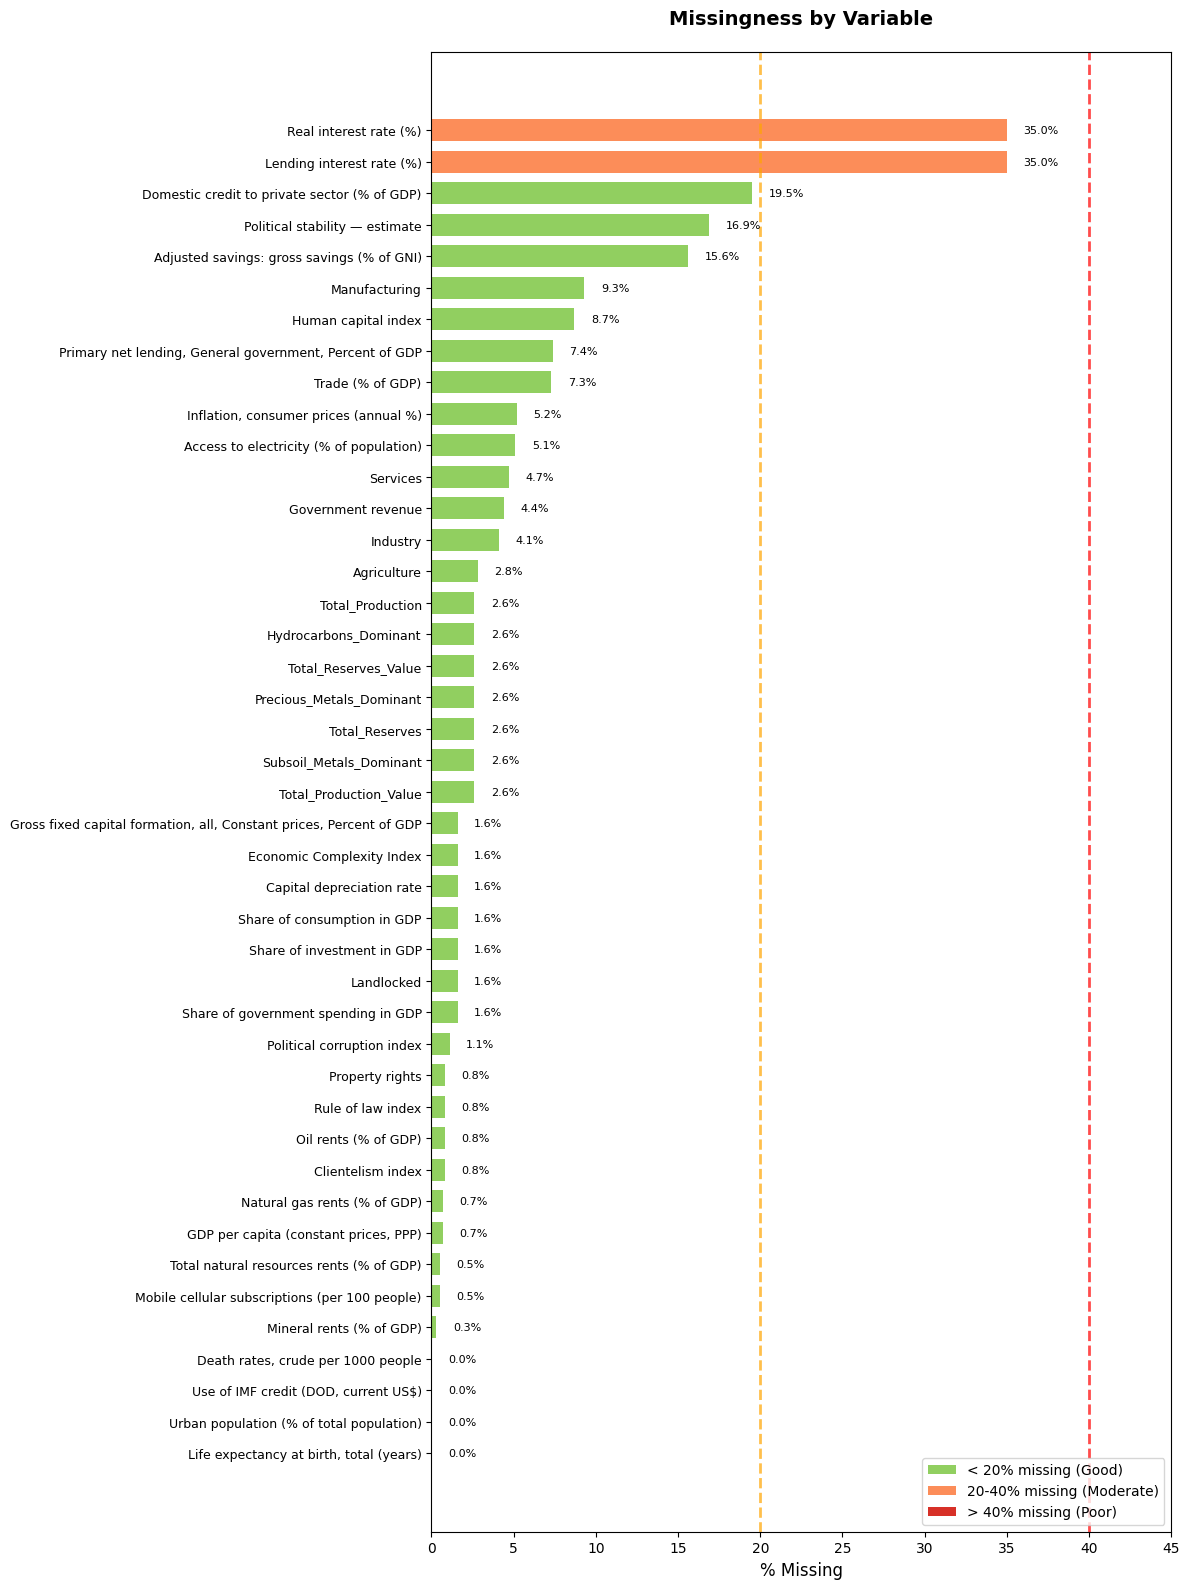

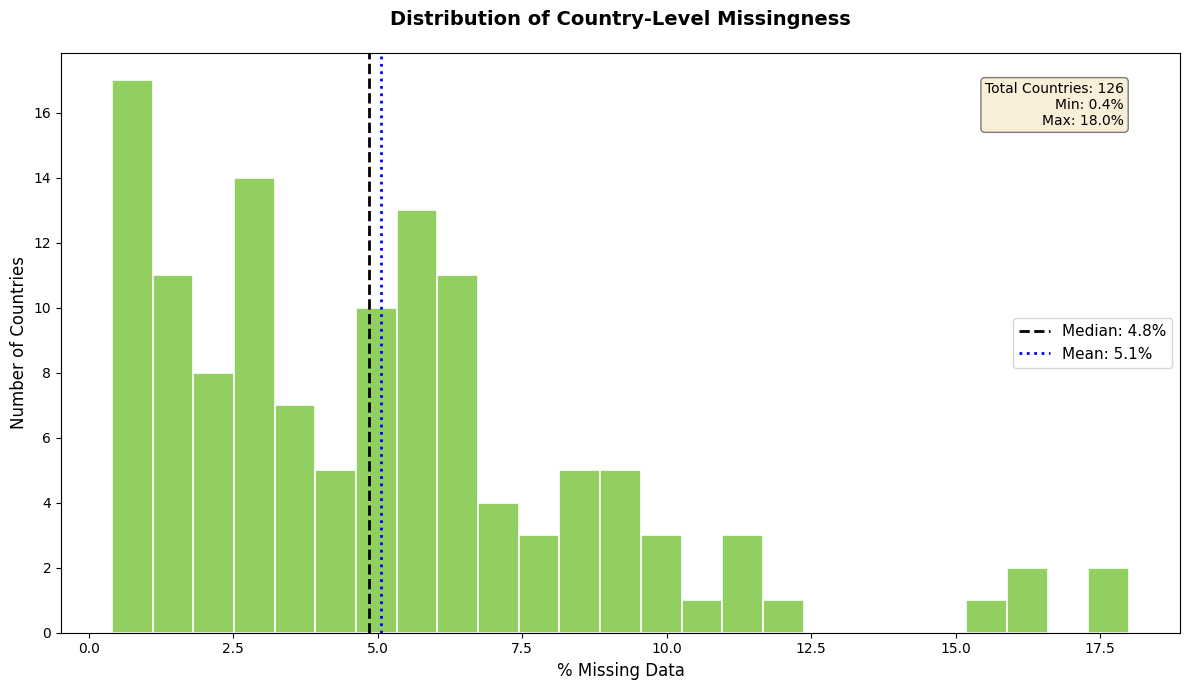

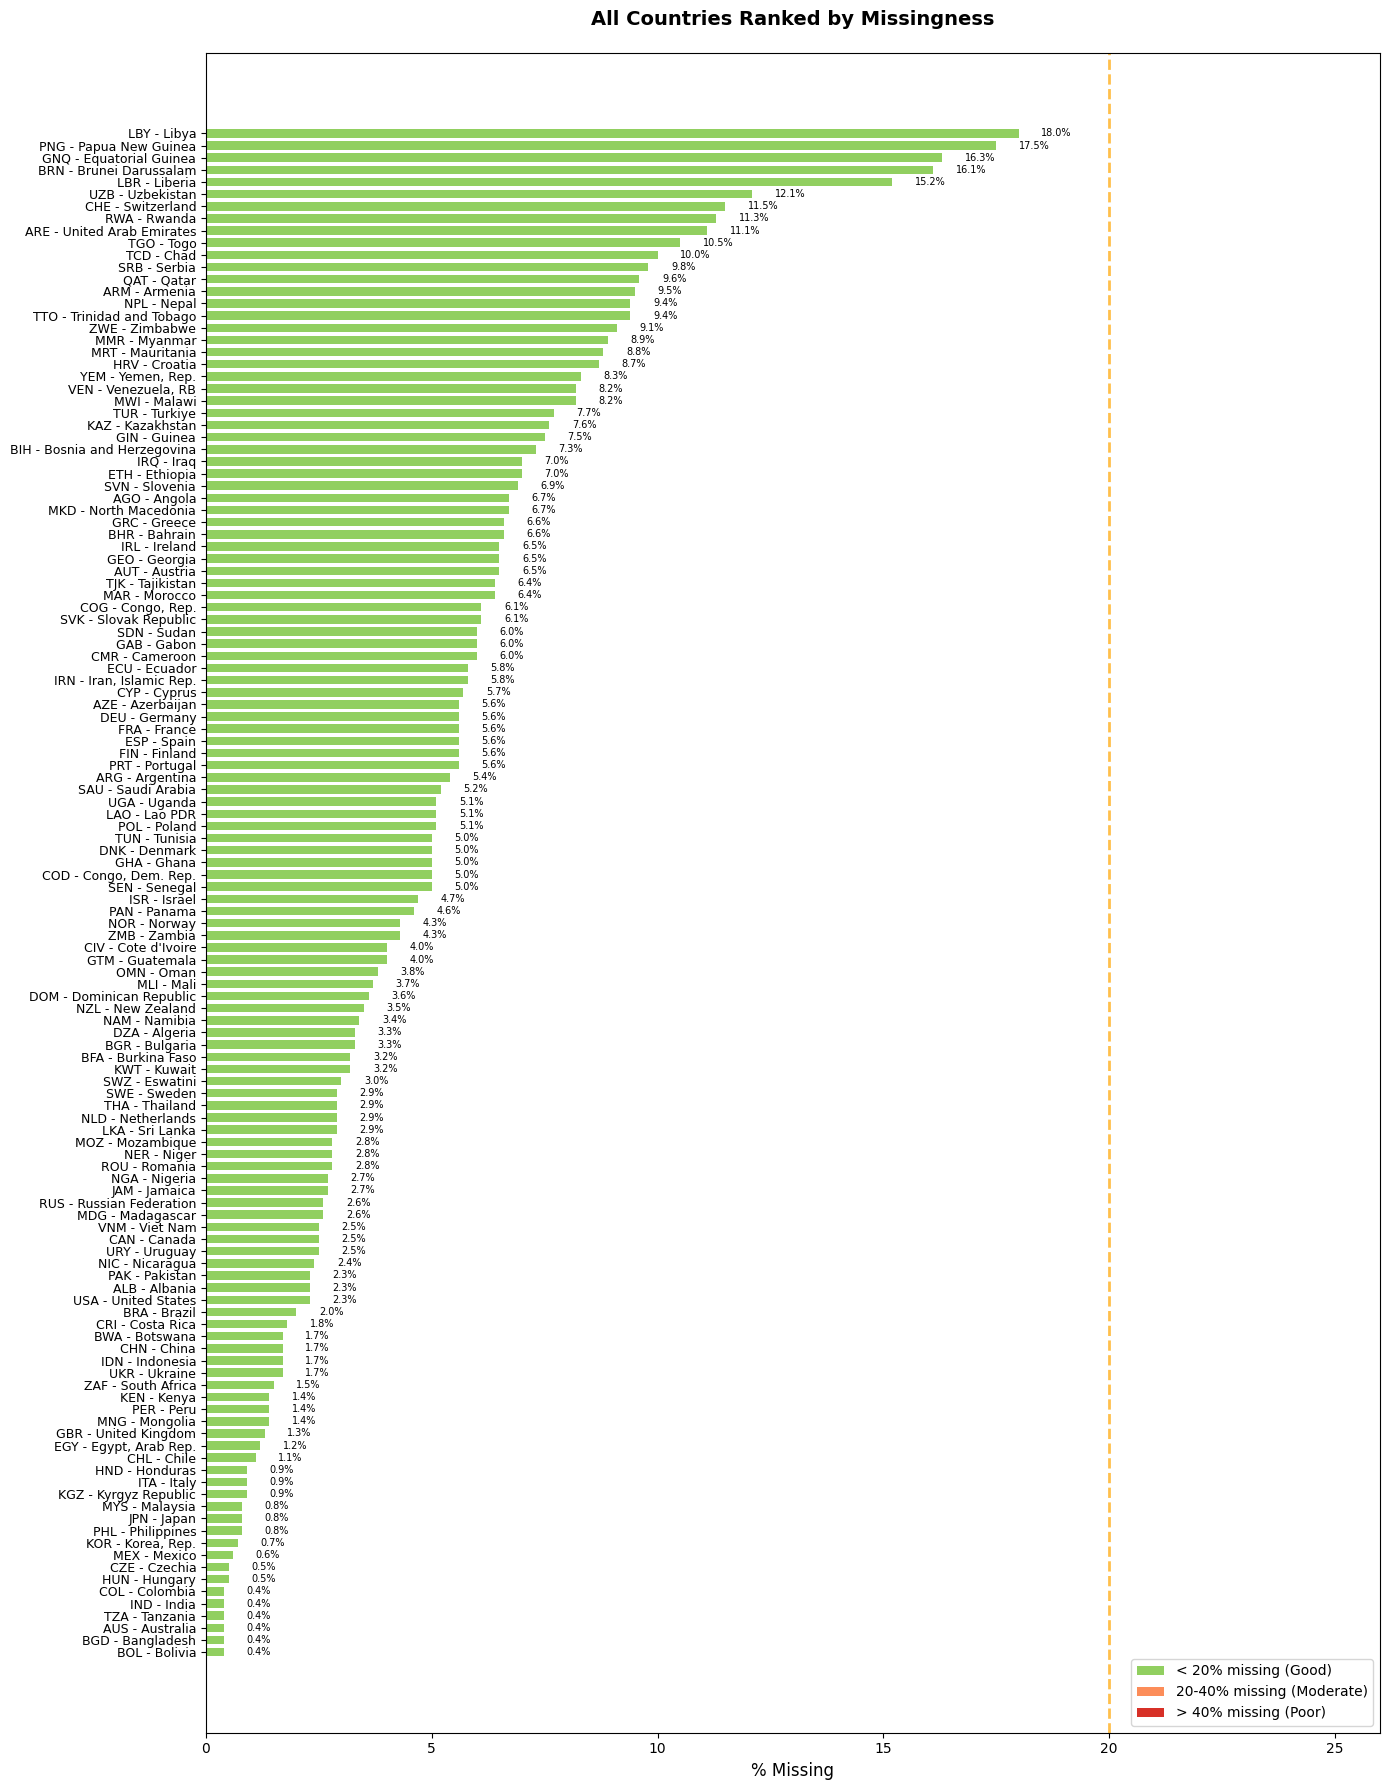

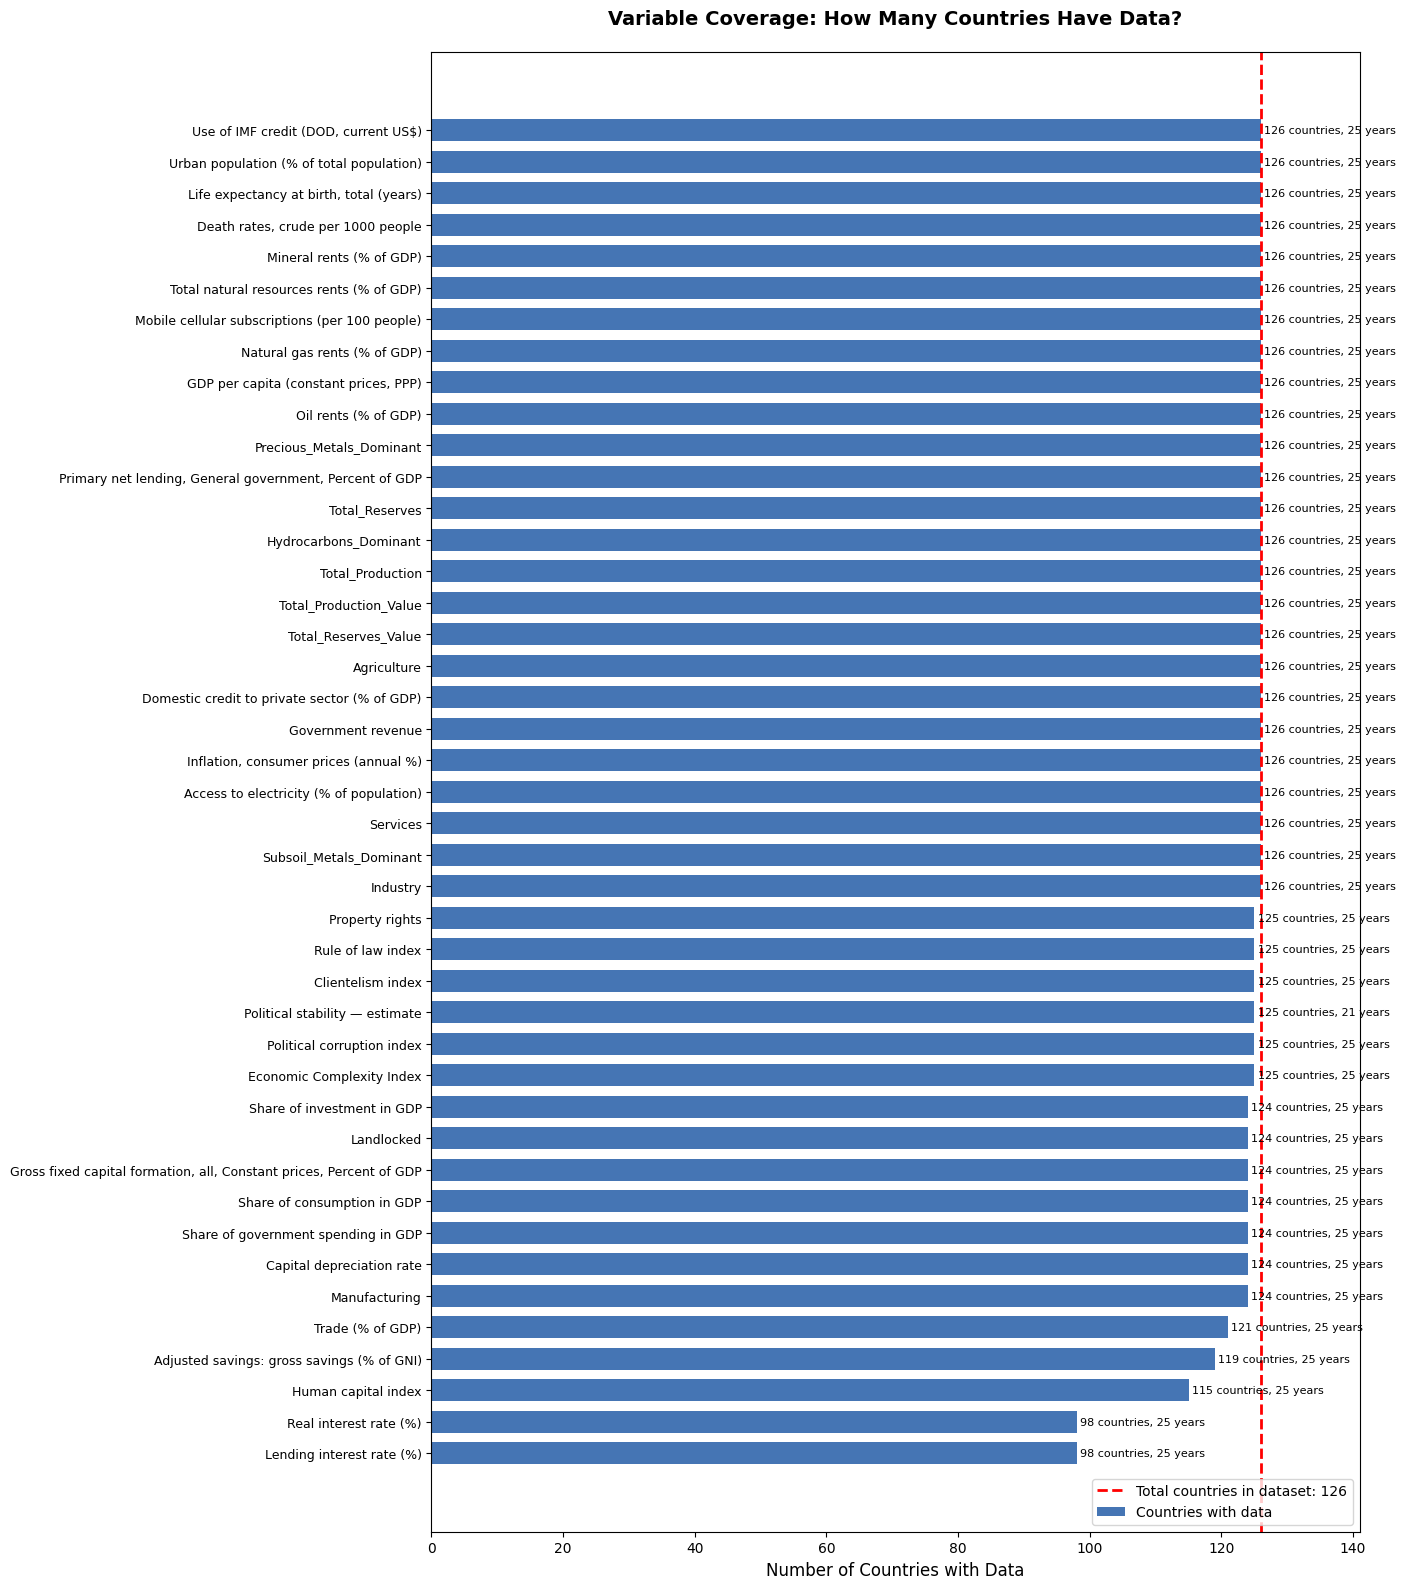

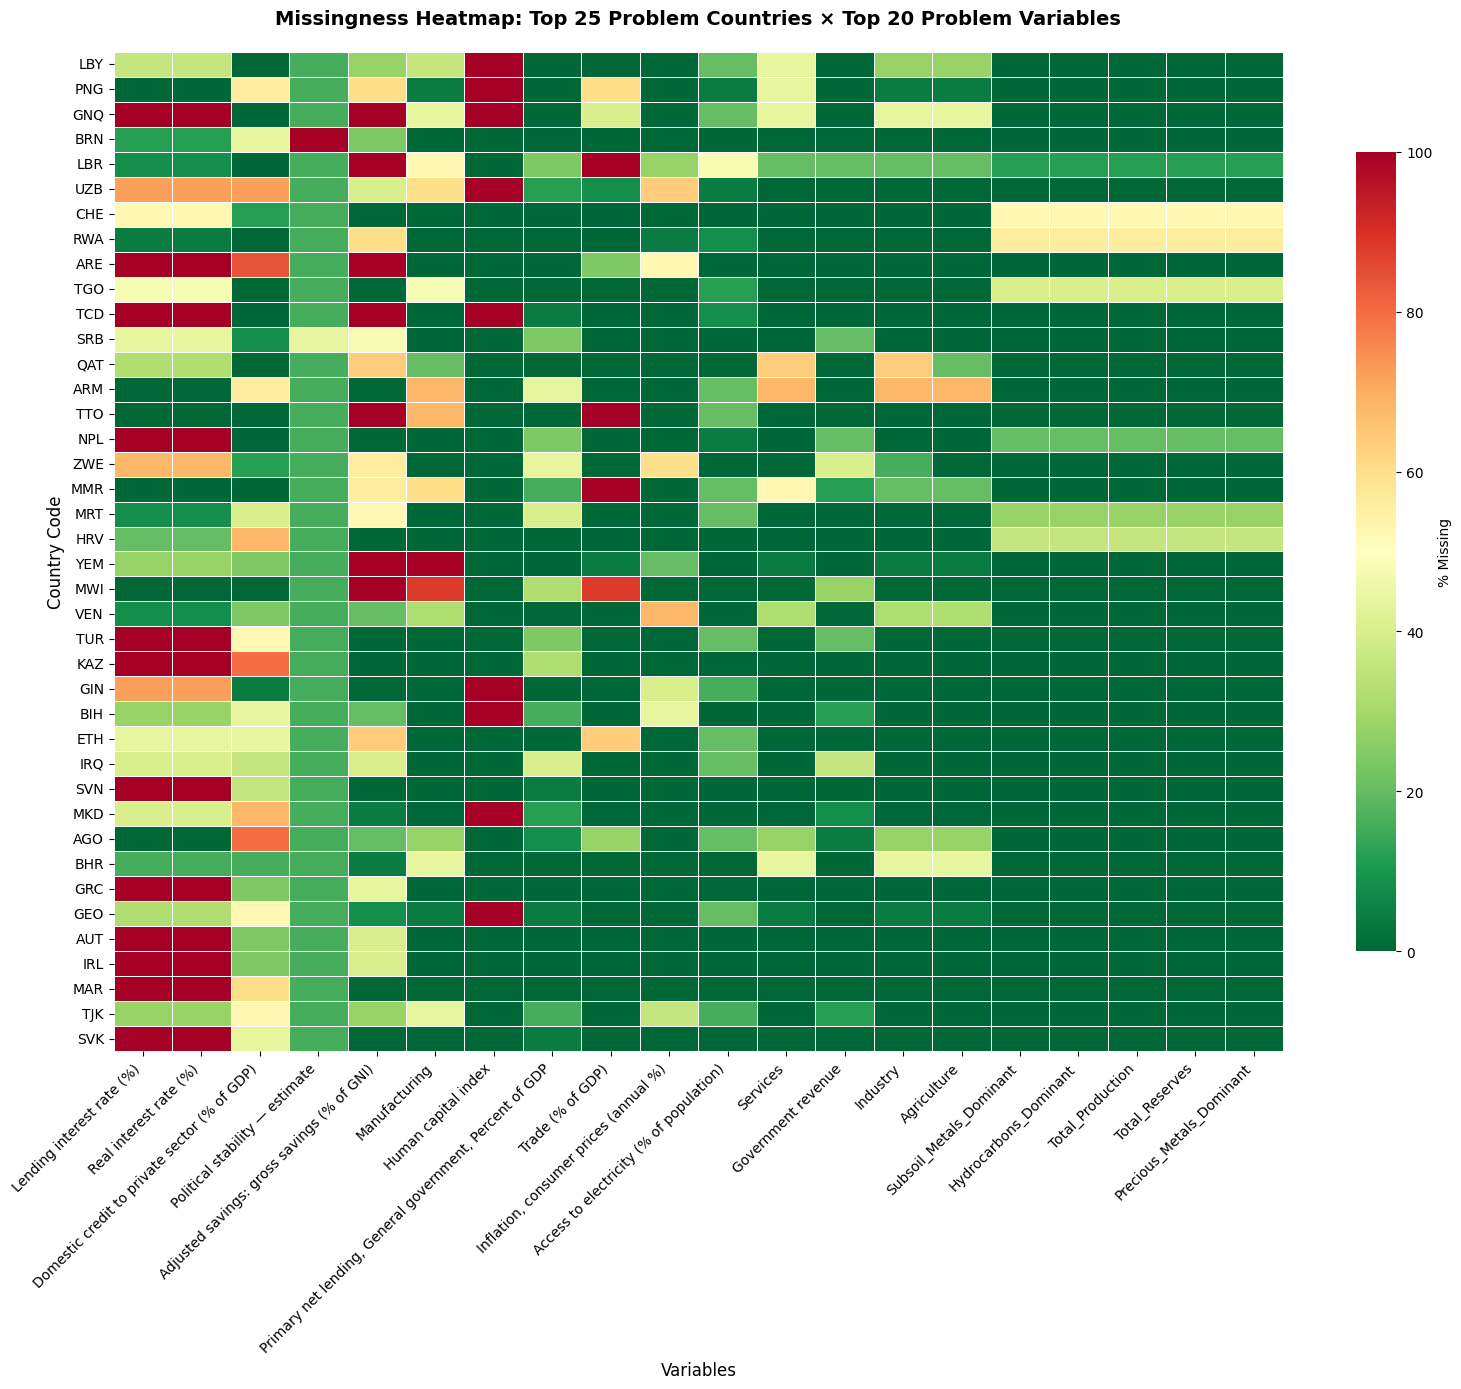

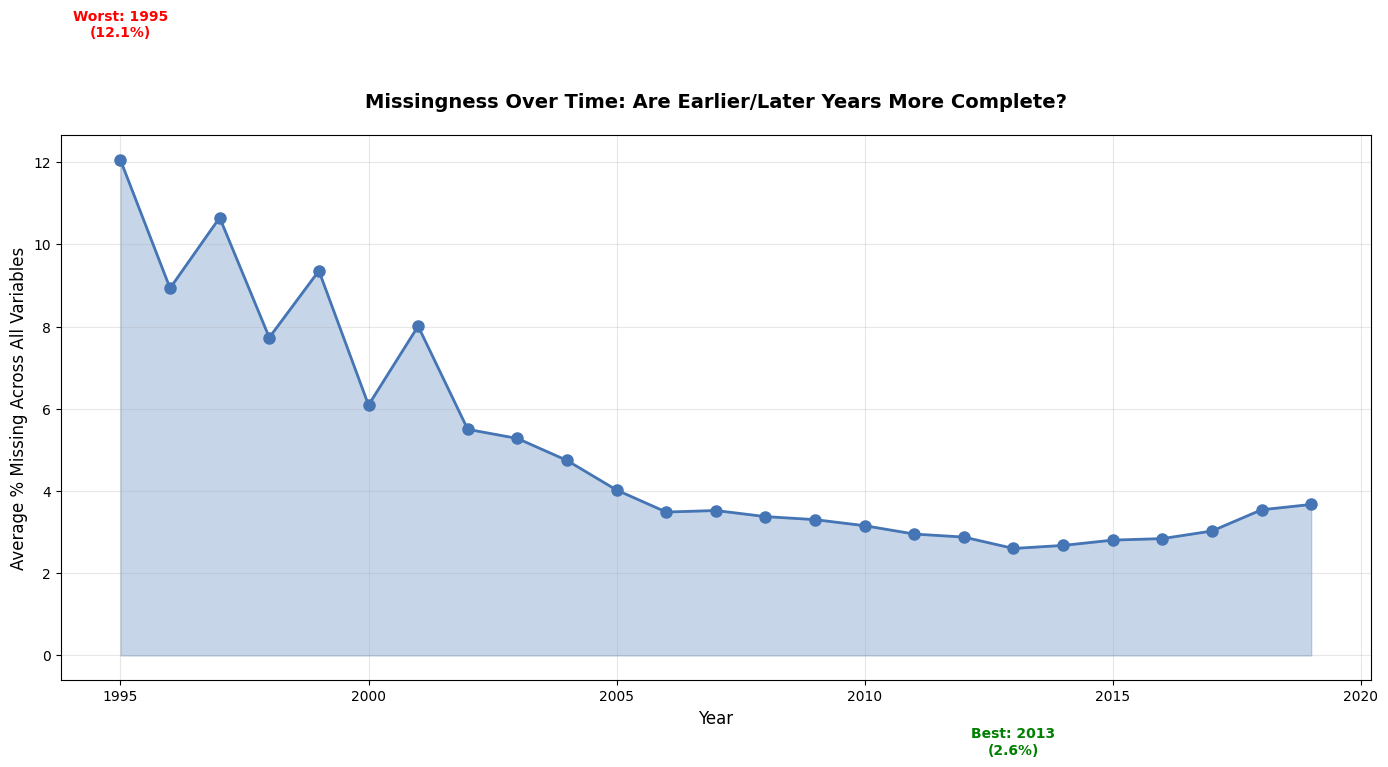


All plots saved as separate PNG files:
  - plot1_variable_missingness.png
  - plot2_country_distribution.png
  - plot3_all_countries_ranked.png
  - plot4_variable_coverage.png
  - plot5_heatmap_problem_areas.png
  - plot6_missingness_over_time.png


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ============================================================
# PLOT 1: Variable Missingness (Full Detail)
# ============================================================
fig1, ax1 = plt.subplots(figsize=(12, 16))

var_sorted = var_missing.sort_values('% Missing', ascending=True)
colors = ['#d73027' if x > 40 else '#fc8d59' if x > 20 else '#91cf60' for x in var_sorted['% Missing']]

bars = ax1.barh(range(len(var_sorted)), var_sorted['% Missing'], color=colors, height=0.7)
ax1.set_xlabel('% Missing', fontsize=12)
ax1.set_title('Missingness by Variable', fontsize=14, fontweight='bold', pad=20)
ax1.set_yticks(range(len(var_sorted)))
ax1.set_yticklabels(var_sorted['Variable'], fontsize=9)
ax1.axvline(x=20, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax1.axvline(x=40, color='red', linestyle='--', alpha=0.7, linewidth=2)

# Add value labels on bars
for i, (val, var) in enumerate(zip(var_sorted['% Missing'], var_sorted['Variable'])):
    ax1.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#91cf60', label='< 20% missing (Good)'),
    Patch(facecolor='#fc8d59', label='20-40% missing (Moderate)'),
    Patch(facecolor='#d73027', label='> 40% missing (Poor)')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)
ax1.set_xlim(0, max(var_sorted['% Missing']) + 10)

plt.tight_layout()
plt.savefig('plot1_variable_missingness.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 2: Country Missingness Distribution
# ============================================================
fig2, ax2 = plt.subplots(figsize=(12, 7))

n, bins, patches = ax2.hist(country_missing['% Missing'], bins=25, color='steelblue', 
                             edgecolor='white', linewidth=1.2)

# Color bins by severity
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    if bin_center > 40:
        patch.set_facecolor('#d73027')
    elif bin_center > 20:
        patch.set_facecolor('#fc8d59')
    else:
        patch.set_facecolor('#91cf60')

ax2.axvline(country_missing['% Missing'].median(), color='black', linestyle='--', 
            linewidth=2, label=f"Median: {country_missing['% Missing'].median():.1f}%")
ax2.axvline(country_missing['% Missing'].mean(), color='blue', linestyle=':', 
            linewidth=2, label=f"Mean: {country_missing['% Missing'].mean():.1f}%")

ax2.set_xlabel('% Missing Data', fontsize=12)
ax2.set_ylabel('Number of Countries', fontsize=12)
ax2.set_title('Distribution of Country-Level Missingness', fontsize=14, fontweight='bold', pad=20)
ax2.legend(fontsize=11)

# Add summary text
textstr = f'Total Countries: {len(country_missing)}\nMin: {country_missing["% Missing"].min():.1f}%\nMax: {country_missing["% Missing"].max():.1f}%'
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('plot2_country_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 3: All Countries Ranked by Missingness
# ============================================================
fig3, ax3 = plt.subplots(figsize=(14, 18))

country_sorted = country_missing.sort_values('% Missing', ascending=True)
colors = ['#d73027' if x > 40 else '#fc8d59' if x > 20 else '#91cf60' for x in country_sorted['% Missing']]

ax3.barh(range(len(country_sorted)), country_sorted['% Missing'], color=colors, height=0.7)
ax3.set_yticks(range(len(country_sorted)))

labels = [f"{row['Code']} - {str(row['Country'])[:25] if pd.notna(row['Country']) else 'N/A'}" 
          for _, row in country_sorted.iterrows()]
ax3.set_yticklabels(labels, fontsize=9)

ax3.set_xlabel('% Missing', fontsize=12)
ax3.set_title('All Countries Ranked by Missingness', fontsize=14, fontweight='bold', pad=20)
ax3.axvline(x=20, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax3.axvline(x=40, color='red', linestyle='--', alpha=0.7, linewidth=2)

# Add value labels
for i, val in enumerate(country_sorted['% Missing']):
    ax3.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=7)

ax3.legend(handles=legend_elements, loc='lower right', fontsize=10)
ax3.set_xlim(0, max(country_sorted['% Missing']) + 8)

plt.tight_layout()
plt.savefig('plot3_all_countries_ranked.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 4: Variable Coverage (Countries & Years)
# ============================================================
fig4, ax4 = plt.subplots(figsize=(14, 16))

var_sorted2 = var_missing.sort_values('Countries', ascending=True)

ax4.barh(range(len(var_sorted2)), var_sorted2['Countries'], color='#4575b4', 
         height=0.7, label='Countries with data')

ax4.set_yticks(range(len(var_sorted2)))
ax4.set_yticklabels(var_sorted2['Variable'], fontsize=9)
ax4.set_xlabel('Number of Countries with Data', fontsize=12)
ax4.set_title('Variable Coverage: How Many Countries Have Data?', fontsize=14, fontweight='bold', pad=20)

# Add total countries line
total_countries = cmaster['Country Code'].nunique()
ax4.axvline(x=total_countries, color='red', linestyle='--', linewidth=2, 
            label=f'Total countries in dataset: {total_countries}')

# Add value labels
for i, (countries, years) in enumerate(zip(var_sorted2['Countries'], var_sorted2['Years'])):
    ax4.text(countries + 0.5, i, f'{countries} countries, {years} years', va='center', fontsize=8)

ax4.legend(loc='lower right', fontsize=10)
ax4.set_xlim(0, total_countries + 15)

plt.tight_layout()
plt.savefig('plot4_variable_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 5: Heatmap - Countries vs Key Variables
# ============================================================
fig5, ax5 = plt.subplots(figsize=(16, 14))

data_cols = [c for c in cmaster.columns if c not in ['Country Code', 'Country Name', 'Year']]
missing_matrix = cmaster.groupby('Country Code')[data_cols].apply(lambda x: x.isna().mean() * 100)

# Select top 25 most problematic countries and top 20 variables
top_countries = country_missing.head(40)['Code'].tolist()
top_vars = var_missing.head(20)['Variable'].tolist()

heatmap_data = missing_matrix.loc[top_countries, top_vars]

sns.heatmap(heatmap_data, cmap='RdYlGn_r', ax=ax5, 
            cbar_kws={'label': '% Missing', 'shrink': 0.8},
            xticklabels=True, yticklabels=True,
            linewidths=0.5, linecolor='white',
            vmin=0, vmax=100)

ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax5.set_yticklabels(ax5.get_yticklabels(), fontsize=10)
ax5.set_title('Missingness Heatmap: Top 25 Problem Countries × Top 20 Problem Variables', 
              fontsize=14, fontweight='bold', pad=20)
ax5.set_xlabel('Variables', fontsize=12)
ax5.set_ylabel('Country Code', fontsize=12)

plt.tight_layout()
plt.savefig('plot5_heatmap_problem_areas.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# PLOT 6: Missingness Over Time
# ============================================================
fig6, ax6 = plt.subplots(figsize=(14, 8))

# Calculate missingness by year
yearly_missing = cmaster.groupby('Year')[data_cols].apply(lambda x: x.isna().mean() * 100).mean(axis=1)
yearly_missing = yearly_missing.dropna()

ax6.plot(yearly_missing.index, yearly_missing.values, marker='o', linewidth=2, 
         markersize=8, color='#4575b4')
ax6.fill_between(yearly_missing.index, yearly_missing.values, alpha=0.3, color='#4575b4')

ax6.set_xlabel('Year', fontsize=12)
ax6.set_ylabel('Average % Missing Across All Variables', fontsize=12)
ax6.set_title('Missingness Over Time: Are Earlier/Later Years More Complete?', 
              fontsize=14, fontweight='bold', pad=20)
ax6.grid(True, alpha=0.3)

# Add annotations for min/max
min_year = yearly_missing.idxmin()
max_year = yearly_missing.idxmax()
ax6.annotate(f'Best: {min_year:.0f}\n({yearly_missing[min_year]:.1f}%)', 
             xy=(min_year, yearly_missing[min_year]), fontsize=10,
             xytext=(min_year, yearly_missing[min_year] - 5),
             ha='center', color='green', fontweight='bold')
ax6.annotate(f'Worst: {max_year:.0f}\n({yearly_missing[max_year]:.1f}%)', 
             xy=(max_year, yearly_missing[max_year]), fontsize=10,
             xytext=(max_year, yearly_missing[max_year] + 3),
             ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('plot6_missingness_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("All plots saved as separate PNG files:")
print("  - plot1_variable_missingness.png")
print("  - plot2_country_distribution.png")
print("  - plot3_all_countries_ranked.png")
print("  - plot4_variable_coverage.png")
print("  - plot5_heatmap_problem_areas.png")
print("  - plot6_missingness_over_time.png")
print("="*60)

In [28]:
import plotly.express as px
import plotly.graph_objects as go

# Create interactive scatter plot
fig = px.scatter(
    country_missing,
    x='Vars with Data',
    y='% Missing',
    color='% Missing',
    color_continuous_scale='RdYlGn_r',
    hover_name='Country',
    hover_data={
        'Code': True,
        'Vars with Data': True,
        '% Missing': ':.1f',
        'Complete Vars': True,
        'Years Covered': True,
        'Rows': True
    },
    title='Country Data Profile: Coverage vs Completeness<br><sup>Hover over points to see country details</sup>',
    labels={
        'Vars with Data': 'Number of Variables with Any Data',
        '% Missing': '% Missing Data Overall',
        'Complete Vars': 'Variables with Complete Data',
        'Years Covered': 'Years Covered'
    }
)

# Update marker styling
fig.update_traces(
    marker=dict(
        size=14,
        line=dict(width=1, color='black'),
        opacity=0.7
    )
)

# Update layout
fig.update_layout(
    width=1000,
    height=700,
    font=dict(size=12),
    title_font=dict(size=16),
    xaxis=dict(
        title_font=dict(size=14),
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    yaxis=dict(
        title_font=dict(size=14),
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    coloraxis_colorbar=dict(
        title='% Missing',
        ticksuffix='%'
    ),
    plot_bgcolor='white',
    hovermode='closest'
)

# Add quadrant lines for reference
median_vars = country_missing['Vars with Data'].median()
median_missing = country_missing['% Missing'].median()

fig.add_hline(y=median_missing, line_dash="dash", line_color="gray", opacity=0.5,
              annotation_text=f"Median: {median_missing:.1f}%", annotation_position="right")
fig.add_vline(x=median_vars, line_dash="dash", line_color="gray", opacity=0.5,
              annotation_text=f"Median: {median_vars:.0f} vars", annotation_position="top")

# Show the plot
fig.show()

# Save as interactive HTML file
fig.write_html('plot7_interactive_country_profile.html')
print("\nInteractive plot saved as 'plot7_interactive_country_profile.html'")
print("Open this file in a browser for full interactivity!")


Interactive plot saved as 'plot7_interactive_country_profile.html'
Open this file in a browser for full interactivity!


In [29]:
import pandas as pd
import numpy as np

EXCLUDE_VARS = [
    'Landlocked',
    'Subsoil_Metals_Dominant',
    'Hydrocarbons_Dominant',
    'Precious_Metals_Dominant',
    'Total_Reserves_Value',
    'Total_Reserves'
]

def impute_missing_values(df):
    """
    Impute missing values using linear interpolation within each country.
    Only fills gaps where the country has at least one observation.
    Excludes dummy and resource value variables.
    """
    
    id_cols = ['Country Code', 'Country Name', 'Year']
    data_cols = [c for c in df.columns if c not in id_cols and c not in EXCLUDE_VARS]
    
    # Pre-imputation stats
    pre_missing = df[data_cols].isna().sum().sum()
    print("=" * 70)
    print("IMPUTATION: Linear interpolation by country")
    print("=" * 70)
    print(f"\nVariables excluded: {[c for c in EXCLUDE_VARS if c in df.columns]}")
    print(f"Variables to impute: {len(data_cols)}")
    print(f"\nTotal missing cells before: {pre_missing:,}")
    
    # Sort by country and year for proper interpolation
    df_sorted = df.sort_values(['Country Code', 'Year']).reset_index(drop=True)
    
    # Impute within each country
    imputed_dfs = []
    for country in df_sorted['Country Code'].unique():
        country_data = df_sorted[df_sorted['Country Code'] == country].copy()
        
        for col in data_cols:
            if country_data[col].notna().any():  # Only if country has some data
                country_data[col] = country_data[col].interpolate(
                    method='linear', limit_direction='both'
                )
        
        imputed_dfs.append(country_data)
    
    df_imputed = pd.concat(imputed_dfs, ignore_index=True)
    
    # Post-imputation stats
    post_missing = df_imputed[data_cols].isna().sum().sum()
    print(f"Total missing cells after: {post_missing:,}")
    print(f"Cells filled: {pre_missing - post_missing:,} ({100*(pre_missing-post_missing)/pre_missing:.1f}%)")
    
    # Show remaining missing
    remaining = df_imputed[data_cols].isna().sum()
    remaining = remaining[remaining > 0].sort_values(ascending=False)
    
    if len(remaining) > 0:
        print(f"\n⚠️  Variables with remaining missing (country has no data):")
        for var, count in remaining.items():
            print(f"   {var}: {count} cells")
    else:
        print("\n✅ All missing values filled!")
    
    return df_imputed

# ============================================================
# RUN
# ============================================================

df_imputed = impute_missing_values(cmaster)
df_imputed

IMPUTATION: Linear interpolation by country

Variables excluded: ['Landlocked', 'Subsoil_Metals_Dominant', 'Hydrocarbons_Dominant', 'Precious_Metals_Dominant', 'Total_Reserves_Value', 'Total_Reserves']
Variables to impute: 37

Total missing cells before: 6,384
Total missing cells after: 2,425
Cells filled: 3,959 (62.0%)

⚠️  Variables with remaining missing (country has no data):
   Lending interest rate (%): 700 cells
   Real interest rate (%): 700 cells
   Human capital index: 275 cells
   Adjusted savings: gross savings (% of GNI): 175 cells
   Trade (% of GDP): 125 cells
   Manufacturing: 50 cells
   Share of consumption in GDP: 50 cells
   Capital depreciation rate: 50 cells
   Gross fixed capital formation, all, Constant prices, Percent of GDP: 50 cells
   Share of investment in GDP: 50 cells
   Share of government spending in GDP: 50 cells
   Clientelism index: 25 cells
   Economic Complexity Index: 25 cells
   Political corruption index: 25 cells
   Rule of law index: 25 cells


,Country Code,Country Name,Year,Access to electricity (% of population),Adjusted savings: gross savings (% of GNI),Agriculture,Capital depreciation rate,Clientelism index,"Death rates, crude per 1000 people",Domestic credit to private sector (% of GDP),Economic Complexity Index,"GDP per capita (constant prices, PPP)",Government revenue,"Gross fixed capital formation, all, Constant prices, Percent of GDP",Human capital index,Industry,"Inflation, consumer prices (annual %)",Landlocked,Lending interest rate (%),"Life expectancy at birth, total (years)",Manufacturing,Mineral rents (% of GDP),Mobile cellular subscriptions (per 100 people),Natural gas rents (% of GDP),Oil rents (% of GDP),Political corruption index,Political stability — estimate,"Primary net lending, General government, Percent of GDP",Property rights,Real interest rate (%),Rule of law index,Services,Share of consumption in GDP,Share of government spending in GDP,Share of investment in GDP,Total natural resources rents (% of GDP),Trade (% of GDP),Urban population (% of total population),"Use of IMF credit (DOD, current US$)",Total_Production,Total_Reserves,Total_Production_Value,Total_Reserves_Value,Hydrocarbons_Dominant,Subsoil_Metals_Dominant,Precious_Metals_Dominant
0,AGO,Angola,1995,24.2,48.055414,9.386791,0.035367,0.840,18.700,22.274928,-1.914,4214.831,39.104,51.161421,1.214912,51.919652,2666.450593,0.0,206.250000,46.139,3.726575,0.000000,0.014333,0.206519,41.018816,0.809,-2.062,4.143154,0.189,-84.095000,0.174,37.980422,0.279740,0.248555,0.624452,44.210997,90.570821,6056809.0,0.0,6.328546e+05,3125.0,1.253085e+07,61876.613480,1.0,0.0,0.0
1,AGO,Angola,1996,24.2,48.055414,9.386791,0.038398,0.840,18.445,22.274928,-2.328,4533.696,39.104,67.195775,1.230892,51.919652,4145.105982,0.0,217.875000,46.418,3.726575,0.000000,0.022929,0.159734,39.074144,0.809,-2.062,4.143154,0.189,-93.513459,0.174,37.980422,0.214948,0.084098,0.734222,41.361717,90.570821,6441501.0,0.0,7.159761e+05,3695.0,1.614997e+07,83346.553264,1.0,0.0,0.0
2,AGO,Angola,1997,24.2,48.055414,9.386791,0.040405,0.840,18.184,22.274928,-1.570,4703.960,34.882,48.507818,1.247082,51.919652,219.176721,0.0,37.750000,46.688,3.726575,0.000000,0.047421,0.158566,37.349023,0.809,-2.190,4.143154,0.189,-29.522707,0.174,37.980422,0.293121,0.256249,0.551628,39.451489,90.570821,6849440.0,0.0,7.410000e+05,3900.0,1.480903e+07,77942.237484,1.0,0.0,0.0
3,AGO,Angola,1998,24.2,48.055414,9.386791,0.040825,0.840,18.925,22.274928,-1.579,4765.766,27.629,64.038521,1.263485,51.919652,107.284822,0.0,45.000000,45.452,3.726575,0.000000,0.063904,0.136441,21.747680,0.809,-2.318,0.172709,0.189,4.047559,0.174,37.980422,0.393799,0.129607,0.714910,24.269381,90.570821,7275437.0,0.0,7.308493e+05,4030.0,9.293232e+06,51244.115764,1.0,0.0,0.0
4,AGO,Angola,1999,24.2,48.055414,9.386791,0.041406,0.840,18.518,22.274928,-1.505,4715.120,41.128,50.738731,1.280103,51.919652,248.195902,0.0,80.296667,45.808,3.726575,0.000000,0.151222,0.161429,38.524270,0.809,-2.178,-2.476901,0.189,-72.578500,0.174,37.980422,0.328058,0.291532,0.584637,40.803354,90.570821,7717606.0,374707057.4,7.450603e+05,5050.0,1.284780e+07,87082.036358,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,ZWE,Zimbabwe,2015,33.7,-11.438012,8.284831,0.054977,0.642,9.180,18.315744,-0.836,2317.436,18.714,0.034396,2.584653,22.358655,-2.430968,1.0,8.541771,58.989,11.888401,0.804563,88.599200,0.000000,0.022608,0.743,-0.619,-0.815856,0.580,7.886493,0.308,58.650946,0.941749,0.173884,0.081855,4.606185,56.749653,4832491.0,463752752.4,4.345331e+06,0.0,6.811226e+08,0.000000,0.0,0.0,1.0
3146,ZWE,Zimbabwe,2016,42.5,-5.670411,7.873585,0.056414,0.656,8.816,17.098496,-1.124,2299.015,17.038,0.000000,2.616257,22.115350,-1.543670,1.0,7.113333,59.760,11.595754,0.903846,88.210000,0.000000,0.022786,0.762,-0.621,-4.216755,0.585,4.846765,0.281,60.409548,0.886755,0.165716,0.0

In [30]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define variables to exclude from imputation
EXCLUDE_VARS = [
    'Landlocked',
    'Subsoil_Metals_Dominant',
    'Hydrocarbons_Dominant',
    'Precious_Metals_Dominant',
    'Total_Production_Value',
    'Total_Reserves_Value',
    'Total_Production',
    'Total_Reserves'
]

def validate_knn_imputer(df, test_fraction=0.05, n_neighbors=5, random_state=42):
    """
    Validate KNNImputer by:
    1. Artificially masking some known values
    2. Imputing them
    3. Comparing predictions to actual values
    """
    
    id_cols = ['Country Code', 'Country Name', 'Year']
    numeric_cols = [c for c in df.columns 
                    if c not in id_cols 
                    and c not in EXCLUDE_VARS
                    and df[c].dtype in ['float64', 'int64']]
    
    print("=" * 70)
    print("KNN IMPUTER VALIDATION TEST")
    print("=" * 70)
    print(f"\nVariables to impute: {len(numeric_cols)}")
    print(f"Variables excluded: {[d for d in EXCLUDE_VARS if d in df.columns]}")
    print(f"n_neighbors: {n_neighbors}")
    
    # Work with numeric data only
    df_numeric = df[numeric_cols].copy()
    
    # Get indices of all non-missing values
    np.random.seed(random_state)
    non_missing_mask = ~df_numeric.isna()
    non_missing_indices = list(zip(*np.where(non_missing_mask)))
    
    # Randomly select some to mask
    n_to_mask = int(len(non_missing_indices) * test_fraction)
    test_indices = np.random.choice(len(non_missing_indices), size=n_to_mask, replace=False)
    test_positions = [non_missing_indices[i] for i in test_indices]
    
    print(f"\nTotal non-missing cells: {len(non_missing_indices):,}")
    print(f"Cells masked for testing: {n_to_mask:,} ({test_fraction*100:.0f}%)")
    
    # Store true values before masking
    true_values = []
    for row, col in test_positions:
        true_values.append({
            'row': row,
            'col': col,
            'variable': numeric_cols[col],
            'true_value': df_numeric.iloc[row, col]
        })
    
    # Create masked dataset
    df_masked = df_numeric.copy()
    for row, col in test_positions:
        df_masked.iloc[row, col] = np.nan
    
    print(f"Missing after masking: {df_masked.isna().sum().sum():,}")
    
    # Scale data (KNN is distance-based, so scaling matters)
    print("\nScaling data and running KNNImputer...")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_masked.fillna(df_masked.mean())),
        columns=numeric_cols
    )
    
    # Reintroduce NaNs after scaling
    df_scaled[df_masked.isna()] = np.nan
    
    # Run KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
    df_imputed_scaled = imputer.fit_transform(df_scaled)
    
    # Inverse transform back to original scale
    df_imputed = pd.DataFrame(
        scaler.inverse_transform(df_imputed_scaled),
        columns=numeric_cols
    )
    
    # Extract predicted values
    for item in true_values:
        item['predicted_value'] = df_imputed.iloc[item['row'], item['col']]
        item['error'] = item['predicted_value'] - item['true_value']
        item['abs_error'] = abs(item['error'])
        item['pct_error'] = 100 * item['abs_error'] / abs(item['true_value']) if item['true_value'] != 0 else np.nan
    
    results_df = pd.DataFrame(true_values)
    
    # Overall metrics
    print("\n" + "=" * 70)
    print("OVERALL RESULTS")
    print("=" * 70)
    
    y_true = results_df['true_value'].values
    y_pred = results_df['predicted_value'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = results_df['pct_error'].median()
    
    print(f"\nR² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Median % Error: {mape:.2f}%")
    
    # Results by variable
    print("\n" + "=" * 70)
    print("RESULTS BY VARIABLE")
    print("=" * 70)
    
    var_results = results_df.groupby('variable').agg({
        'true_value': 'count',
        'abs_error': 'mean',
        'pct_error': 'median'
    }).rename(columns={
        'true_value': 'n_tested',
        'abs_error': 'mean_abs_error',
        'pct_error': 'median_pct_error'
    }).sort_values('median_pct_error', ascending=False)
    
    print("\nVariables with HIGHEST error:")
    print(var_results.head(10).to_string())
    
    print("\nVariables with LOWEST error:")
    print(var_results.tail(10).to_string())
    
    # Sample predictions
    print("\n" + "=" * 70)
    print("SAMPLE PREDICTIONS (random 20)")
    print("=" * 70)
    sample = results_df.sample(min(20, len(results_df)), random_state=random_state)
    sample_display = sample[['variable', 'true_value', 'predicted_value', 'pct_error']].copy()
    sample_display['true_value'] = sample_display['true_value'].round(2)
    sample_display['predicted_value'] = sample_display['predicted_value'].round(2)
    sample_display['pct_error'] = sample_display['pct_error'].round(1)
    print(sample_display.to_string(index=False))
    
    return results_df, var_results

# ============================================================
# RUN VALIDATION
# ============================================================

results_df, var_results = validate_knn_imputer(df_imputed, test_fraction=0.05, n_neighbors=5)

# ============================================================
# ACTUAL IMPUTATION (run after you're happy with validation)
# ============================================================

def apply_knn_imputer(df, n_neighbors=5):
    """Apply KNNImputer to fill remaining missing values."""
    
    id_cols = ['Country Code', 'Country Name', 'Year']
    numeric_cols = [c for c in df.columns 
                    if c not in id_cols 
                    and c not in EXCLUDE_VARS
                    and df[c].dtype in ['float64', 'int64']]
    
    print("=" * 70)
    print("APPLYING KNN IMPUTATION")
    print("=" * 70)
    
    pre_missing = df[numeric_cols].isna().sum().sum()
    print(f"\nMissing before: {pre_missing:,}")
    
    # Scale
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[numeric_cols].fillna(df[numeric_cols].mean())),
        columns=numeric_cols
    )
    df_scaled[df[numeric_cols].isna()] = np.nan
    
    # Impute
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
    imputed_array = imputer.fit_transform(df_scaled)
    
    # Inverse transform
    imputed_values = scaler.inverse_transform(imputed_array)
    
    # Create final dataframe
    df_final = df.copy()
    df_final[numeric_cols] = imputed_values
    
    post_missing = df_final[numeric_cols].isna().sum().sum()
    print(f"Missing after: {post_missing:,}")
    print(f"✅ Filled: {pre_missing - post_missing:,} cells")
    
    # Check excluded vars
    excluded_missing = df_final[EXCLUDE_VARS].isna().sum().sum() if any(c in df.columns for c in EXCLUDE_VARS) else 0
    print(f"\nExcluded variables (not imputed): {[c for c in EXCLUDE_VARS if c in df.columns]}")
    print(f"Missing in excluded vars: {excluded_missing}")
    
    return df_final

# Run imputation
cmaster_imp = apply_knn_imputer(df_imputed, n_neighbors=5)

KNN IMPUTER VALIDATION TEST

Variables to impute: 35
Variables excluded: ['Landlocked', 'Subsoil_Metals_Dominant', 'Hydrocarbons_Dominant', 'Precious_Metals_Dominant', 'Total_Production_Value', 'Total_Reserves_Value', 'Total_Production', 'Total_Reserves']
n_neighbors: 5

Total non-missing cells: 107,825
Cells masked for testing: 5,391 (5%)
Missing after masking: 7,816

Scaling data and running KNNImputer...

OVERALL RESULTS

R² Score: 0.9216
MAE: 3483064.9506
RMSE: 83450717.5339
Median % Error: 4.36%

RESULTS BY VARIABLE

Variables with HIGHEST error:
                                                         n_tested  mean_abs_error  median_pct_error
variable                                                                                           
Primary net lending, General government, Percent of GDP       148    1.767066e+00         52.192975
Mineral rents (% of GDP)                                      169    4.504445e-01         50.570093
Inflation, consumer prices (annual %)     

In [31]:
cmaster_imp.to_csv("../workingdata/master_data_imputed.csv")

## I did some manual filling in (not much) on excel

In [32]:
nrpv.to_csv("../workingdata/NRCleanData.csv")

In [33]:
nrpv

Metric,Country,Year,Resource,Source,Price,Production,Reserves,Production_TotalValue,Reserves_TotalValue,Resource Category
0,Afghanistan,1995.0,Coal,Original,4.581266e+01,140000.000,NaN,6.413772e+06,NaN,Hydrocarbons
1,Afghanistan,1996.0,Coal,Original,4.155228e+01,200000.000,NaN,8.310457e+06,NaN,Hydrocarbons
2,Afghanistan,1997.0,Coal,Original,3.674010e+01,185000.000,NaN,6.796918e+06,NaN,Hydrocarbons
3,Afghanistan,1998.0,Coal,Original,2.923083e+01,190000.000,NaN,5.553858e+06,NaN,Hydrocarbons
4,Afghanistan,1999.0,Coal,Original,2.484547e+01,2000.000,NaN,4.969094e+04,NaN,Hydrocarbons
...,...,...,...,...,...,...,...,...,...,...
17161,Zimbabwe,2021.0,Coal,Original,5.934994e+01,3239215.090,NaN,1.922472e+08,NaN,Hydrocarbons
17162,Zimbabwe,2021.0,Copper,Original,5.764026e+03,8650.000,NaN,4.985883e+07,NaN,Subsoil Metals
17163,Zimbabwe,2021.0,Gold,Original,3.480000e+07,31.477,NaN,1.095400e+09,NaN,Precious Metals
17164,Zimbabwe,2021.0,Lithium,Original,3.730000e+03,710.000,NaN,2.648300e+06,NaN,Subsoil Metals


In [34]:
import pandas as pd
import numpy as np

# =============================================================================
# STEP 1: Load and clean the data
# =============================================================================

# Assuming your dataframe is called df_pop
df_pop = pd.read_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\rawdata\PopulationWDI.csv")

# Remove metadata rows at the bottom (NaN country codes, footer info)
df_pop = df_pop[df_pop['Country Code'].notna()].copy()

# Keep only necessary columns
id_cols = ['Country Name', 'Country Code']
year_cols = [col for col in df_pop.columns if '[YR' in col]

print(f"Year columns found: {len(year_cols)}")
print(f"Countries: {len(df_pop)}")

# =============================================================================
# STEP 2: Melt from wide to long format
# =============================================================================

df_long = pd.melt(
    df_pop,
    id_vars=id_cols,
    value_vars=year_cols,
    var_name='Year_raw',
    value_name='Population'
)

# =============================================================================
# STEP 3: Clean the Year column (extract year from "1995 [YR1995]")
# =============================================================================

# Extract just the year number
df_long['Year'] = df_long['Year_raw'].str.extract(r'(\d{4})').astype(int)

# Drop the raw year column
df_long = df_long.drop(columns=['Year_raw'])

# =============================================================================
# STEP 4: Clean Population values
# =============================================================================

# Convert to numeric (handles ".." or other non-numeric values)
df_long['Population'] = pd.to_numeric(df_long['Population'], errors='coerce')

# =============================================================================
# STEP 5: Reorder columns
# =============================================================================

df_long = df_long[['Country Name', 'Country Code', 'Year', 'Population']]

# Sort for cleanliness
df_long = df_long.sort_values(['Country Name', 'Year']).reset_index(drop=True)

# =============================================================================
# RESULT
# =============================================================================

print("\nTransformed data:")
print(df_long.head(10))

print(f"\nShape: {df_long.shape}")
print(f"Year range: {df_long['Year'].min()} - {df_long['Year'].max()}")
print(f"Countries: {df_long['Country Code'].nunique()}")

# Check for missing values
print(f"\nMissing Population values: {df_long['Population'].isna().sum()}")

Year columns found: 30
Countries: 268

Transformed data:
  Country Name Country Code  Year  Population
0  Afghanistan          AFG  1995  17065836.0
1  Afghanistan          AFG  1996  17763266.0
2  Afghanistan          AFG  1997  18452091.0
3  Afghanistan          AFG  1998  19159996.0
4  Afghanistan          AFG  1999  19887785.0
5  Afghanistan          AFG  2000  20130327.0
6  Afghanistan          AFG  2001  20284307.0
7  Afghanistan          AFG  2002  21378117.0
8  Afghanistan          AFG  2003  22733049.0
9  Afghanistan          AFG  2004  23560654.0

Shape: (8040, 4)
Year range: 1995 - 2024
Countries: 268

Missing Population values: 90


In [40]:
master = pd.read_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\MASTER\Master.csv", index_col = 0) 
nr = pd.read_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\MASTER\NaturalResource.csv", index_col = 0) 

master = master.merge(df_long[["Country Code", "Year", "Population"]], on=["Country Code", "Year"], how='left')

nr = nrpv.merge(master[["Country Name", "Country Code"]], left_on="Country", right_on="Country Name", how="left")
nr = nr.merge(df_long[["Country Code", "Year", "Population"]], on=["Country Code", "Year"], how='left')

master.to_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\MASTER\Master2.csv")
nr.to_csv(r"C:\Users\ayaan\OneDrive - London School of Economics\Academics\MPA_DSPP\Moody's - Capstone Project\Capstone-Ayaan-ASUS\MASTER\NaturalResource2.csv")

In [37]:
list = nr["Country Name"]
nrpv[~nrpv["Country"].isin(list)]


Metric,Country,Year,Resource,Source,Price,Production,Reserves,Production_TotalValue,Reserves_TotalValue,Resource Category
0,Afghanistan,1995.0,Coal,Original,45.812658,140000.000000,NaN,6.413772e+06,NaN,Hydrocarbons
1,Afghanistan,1996.0,Coal,Original,41.552283,200000.000000,NaN,8.310457e+06,NaN,Hydrocarbons
2,Afghanistan,1997.0,Coal,Original,36.740095,185000.000000,NaN,6.796918e+06,NaN,Hydrocarbons
3,Afghanistan,1998.0,Coal,Original,29.230833,190000.000000,NaN,5.553858e+06,NaN,Hydrocarbons
4,Afghanistan,1999.0,Coal,Original,24.845472,2000.000000,NaN,4.969094e+04,NaN,Hydrocarbons
...,...,...,...,...,...,...,...,...,...,...
15457,Turkmenistan,2019.0,Oil,Original,28.222385,254364.931507,600.00,7.178785e+06,16933.430866,Hydrocarbons
15458,Turkmenistan,2020.0,Natural Gas,Original,1.366223,2376.527309,13601.25,3.246866e+03,18582.341579,Hydrocarbons
15459,Turkmenistan,2020.0,Oil,Original,18.039887,218843.951813,600.00,3.947920e+06,10823.932269,Hydrocarbons
15460,Turkmenistan,2021.0,Natural Gas,Original,5.234466,2854.209423,NaN,1.494026e+04,NaN,Hydrocarbons


In [39]:
nrpv

Metric,Country,Year,Resource,Source,Price,Production,Reserves,Production_TotalValue,Reserves_TotalValue,Resource Category
0,Afghanistan,1995.0,Coal,Original,4.581266e+01,140000.000,NaN,6.413772e+06,NaN,Hydrocarbons
1,Afghanistan,1996.0,Coal,Original,4.155228e+01,200000.000,NaN,8.310457e+06,NaN,Hydrocarbons
2,Afghanistan,1997.0,Coal,Original,3.674010e+01,185000.000,NaN,6.796918e+06,NaN,Hydrocarbons
3,Afghanistan,1998.0,Coal,Original,2.923083e+01,190000.000,NaN,5.553858e+06,NaN,Hydrocarbons
4,Afghanistan,1999.0,Coal,Original,2.484547e+01,2000.000,NaN,4.969094e+04,NaN,Hydrocarbons
...,...,...,...,...,...,...,...,...,...,...
17161,Zimbabwe,2021.0,Coal,Original,5.934994e+01,3239215.090,NaN,1.922472e+08,NaN,Hydrocarbons
17162,Zimbabwe,2021.0,Copper,Original,5.764026e+03,8650.000,NaN,4.985883e+07,NaN,Subsoil Metals
17163,Zimbabwe,2021.0,Gold,Original,3.480000e+07,31.477,NaN,1.095400e+09,NaN,Precious Metals
17164,Zimbabwe,2021.0,Lithium,Original,3.730000e+03,710.000,NaN,2.648300e+06,NaN,Subsoil Metals
